# Data Preprocessing & Feature Engineering

## Import Necessary Libraries

In [1]:
# Python Standard Libraries
import os
import csv
import math
import random
import unicodedata

# Data Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP - NLTK
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Bidirectional,
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
    Flatten, GlobalAveragePooling1D, LayerNormalization,
    MultiHeadAttention, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Huber

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# Shap
import shap

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yourth/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Collections

In [2]:
raw_stocks = pd.read_csv('./data/raw/stock_yfinance.csv')
raw_tweets = pd.read_csv('./data/raw/stock_tweets.csv')

## Exploratory Data Analysis & Data Preprocessing

### 1. `stock_yfinance` Dataset

In [3]:
raw_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.320429,212818400,AAPL
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.635286,257142000,AAPL
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.637505,263188400,AAPL
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,23.968958,160423600,AAPL
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.889906,237458000,AAPL


In [4]:
raw_stocks.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
6285,2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,TSLA
6286,2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,TSLA
6287,2019-12-27,29.000000,29.020666,28.407333,28.691999,28.691999,149185500,TSLA
6288,2019-12-30,28.586000,28.600000,27.284000,27.646667,27.646667,188796000,TSLA
6289,2019-12-31,27.000000,28.086000,26.805332,27.888666,27.888666,154285500,TSLA


In [5]:
raw_stocks.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6290.000000,6290.000000,6290.000000,6290.000000,6290.000000,6.290000e+03
mean,47.939449,48.373949,47.468337,47.943927,46.149473,7.857451e+07
std,28.802247,28.991926,28.561164,28.793088,27.501038,6.388470e+07
min,9.488000,10.331333,9.403333,9.578000,9.578000,7.425600e+06
25%,26.413126,26.652000,26.131500,26.448125,24.851683,3.243302e+07
50%,42.177500,42.528000,41.861500,42.233999,40.205023,6.051200e+07
75%,58.738500,59.248500,58.206749,58.749249,57.247396,1.035403e+08
max,159.449997,159.550003,158.220001,158.960007,151.738663,6.488252e+08


In [6]:
raw_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        6290 non-null   object 
 1   Open        6290 non-null   float64
 2   High        6290 non-null   float64
 3   Low         6290 non-null   float64
 4   Close       6290 non-null   float64
 5   Adj Close   6290 non-null   float64
 6   Volume      6290 non-null   int64  
 7   Stock Name  6290 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 393.3+ KB


In [7]:
raw_stocks['Stock Name'].unique()

array(['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA'], dtype=object)

In [8]:
stocks = raw_stocks.copy()

stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.320429,212818400,AAPL
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.635286,257142000,AAPL
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.637505,263188400,AAPL
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,23.968958,160423600,AAPL
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.889906,237458000,AAPL
...,...,...,...,...,...,...,...,...
6285,2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,TSLA
6286,2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,TSLA
6287,2019-12-27,29.000000,29.020666,28.407333,28.691999,28.691999,149185500,TSLA
6288,2019-12-30,28.586000,28.600000,27.284000,27.646667,27.646667,188796000,TSLA


### 2. `stock_tweets` Dataset

In [9]:
raw_tweets.head()

,Tweet ID,Writer,UTC,Tweet,Like Num,Stock Name,Date
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",1,AAPL,2015-01-01 00:00:57+00:00
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,AAPL,2015-01-01 00:01:36+00:00
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,AMZN,2015-01-01 00:01:50+00:00
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,1,TSLA,2015-01-01 00:06:47+00:00
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,1,AAPL,2015-01-01 00:10:05+00:00


In [10]:
raw_tweets.tail()

,Tweet ID,Writer,UTC,Tweet,Like Num,Stock Name,Date
3943871,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,1,TSLA,2019-12-31 23:53:21+00:00
3943872,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,5,TSLA,2019-12-31 23:54:03+00:00
3943873,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,MSFT,2019-12-31 23:55:37+00:00
3943874,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,AAPL,2019-12-31 23:55:37+00:00
3943875,1212160477159206912,treabase,1577836553,"$AAPL #patent 10,522,475 Vertical interconnect...",0,AAPL,2019-12-31 23:55:53+00:00


In [11]:
raw_tweets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3943876 entries, 0 to 3943875
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Tweet ID    3943876 non-null  int64 
 1   Writer      3895635 non-null  object
 2   UTC         3943876 non-null  int64 
 3   Tweet       3943876 non-null  object
 4   Like Num    3943876 non-null  int64 
 5   Stock Name  3943876 non-null  object
 6   Date        3943876 non-null  object
dtypes: int64(3), object(4)
memory usage: 210.6+ MB


In [12]:
tweets = raw_tweets.copy()

tweets = tweets.drop(columns=['Tweet ID', 'Writer', 'UTC', 'Like Num'])
tweets = tweets.dropna(subset=['Date', 'Tweet'])
tweets.isna().sum()

Tweet         0
Stock Name    0
Date          0
dtype: int64

In [13]:
# Make sure Date is in datetime format
tweets['Date'] = pd.to_datetime(tweets['Date'], errors='coerce')
tweets['Date'] = tweets['Date'].dt.date

tweets.head()

,Tweet,Stock Name,Date
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL,2015-01-01
1,Insanity of today weirdo massive selling. $aap...,AAPL,2015-01-01
2,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,AMZN,2015-01-01
3,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,TSLA,2015-01-01
4,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01


In [14]:
tweets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3943876 entries, 0 to 3943875
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Tweet       3943876 non-null  object
 1   Stock Name  3943876 non-null  object
 2   Date        3943876 non-null  object
dtypes: object(3)
memory usage: 90.3+ MB


In [15]:
tweet_stock_count = raw_tweets['Stock Name'].value_counts()

perc = tweet_stock_count / tweet_stock_count.sum()
dstr = pd.DataFrame({'Count': tweet_stock_count, 'Percentage': perc}).reset_index()
dstr = dstr.rename(columns={'index': 'Stock Name'})
dstr.head()

,Stock Name,Count,Percentage
0,AAPL,1425013,0.361323
1,TSLA,1096868,0.278119
2,AMZN,718715,0.182236
3,MSFT,375711,0.095264
4,GOOGL,327569,0.083058


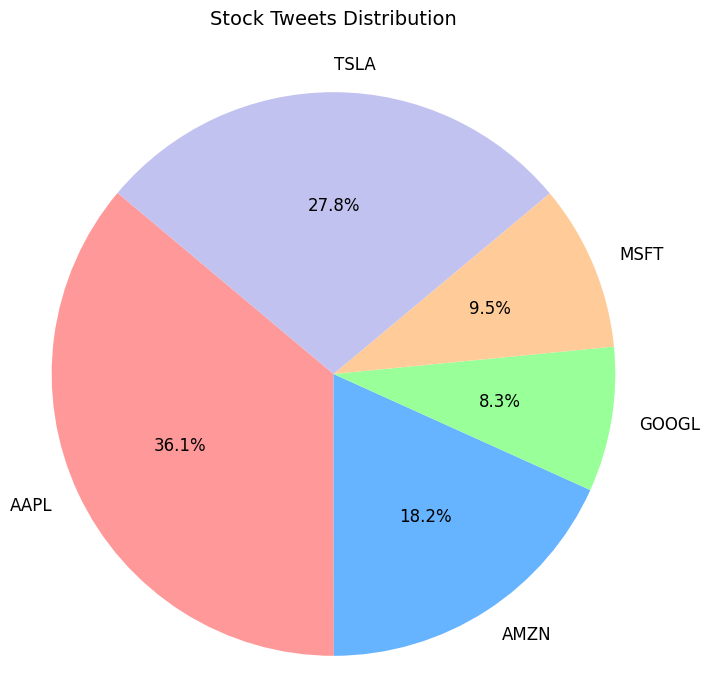

In [16]:
# Set a threshold percentage
threshold = 0.02  # 2%
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c4e17f', '#76d7c4', '#f7c6c7']

# Create a new DataFrame grouping smaller slices
dstr['Grouped'] = dstr.apply(lambda row: 'Other' if row['Percentage'] < threshold else row['Stock Name'], axis=1)

dstr_grouped = dstr.groupby(
    dstr['Grouped'].where(dstr['Grouped'] != 'Other', 'Other')
).agg({'Count': 'sum'}).reset_index()

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    dstr_grouped['Count'],
    labels=dstr_grouped['Grouped'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title('Stock Tweets Distribution', fontsize=14, pad=30)
plt.axis('equal')
plt.show()

In [17]:
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.320429,212818400,AAPL
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.635286,257142000,AAPL
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.637505,263188400,AAPL
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,23.968958,160423600,AAPL
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.889906,237458000,AAPL


In [18]:
tweets.head()

,Tweet,Stock Name,Date
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL,2015-01-01
1,Insanity of today weirdo massive selling. $aap...,AAPL,2015-01-01
2,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,AMZN,2015-01-01
3,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,TSLA,2015-01-01
4,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01


In [19]:
def find_last_trading_day(x, trading_days):
    """
    给定一个日期 x，从 trading_days 中找到最近且不晚于 x 的交易日。
    
    返回：
        最近的交易日（若不存在则为 NaT）
    """
    eligible_days = trading_days[trading_days <= x]
    if not eligible_days.empty:
        return eligible_days.max()
    else:
        return pd.NaT

def map_to_last_trading_day(tweet_dates, trading_days):
    """
    将所有推文日期映射到最近的交易日（向下取）
    
    参数：
        tweet_dates: Series 或 DatetimeIndex（推文时间）
        trading_days: 可迭代对象，包含所有合法交易日
    
    返回：
        Series：每条推文对应的最近交易日
    """
    trading_days = pd.to_datetime(sorted(set(trading_days)))

    # 使用 apply + lambda 调用子函数
    mapped_dates = tweet_dates.apply(lambda x: find_last_trading_day(x, trading_days))

    # 过滤掉找不到对应交易日的 NaT
    valid_mask = mapped_dates.notna()

    return mapped_dates[valid_mask]

In [20]:
# 预处理
tweets['Date'] = pd.to_datetime(tweets['Date'])
stocks['Date'] = pd.to_datetime(stocks['Date'])

# 获取交易日列表
trading_days = stocks['Date'].unique()

# 映射并过滤
mapped_dates = map_to_last_trading_day(tweets['Date'], trading_days)

# 将有效结果加入 tweets（只有成功匹配交易日的）
tweets = tweets.loc[mapped_dates.index].copy()
tweets['Trading Date'] = mapped_dates

In [21]:
tweets['Date'] = tweets['Trading Date']
tweets = tweets.drop(columns=['Trading Date'])  # 可选：删除旧列

tweets.head()

,Tweet,Stock Name,Date
628,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,AMZN,2015-01-02
629,Will Audi's Electric Q7 Cause $TSLA Model X Ba...,TSLA,2015-01-02
630,Either way you're a winnah. RT @dbbrakebill: i...,AAPL,2015-01-02
631,@Weeklyoptions http://Weeklyoptionplays.com we...,AAPL,2015-01-02
632,"Cash flow machine. RT @themandotcom: $MSFT, wh...",MSFT,2015-01-02


## Feature Construction

### 1. Sentiment Analysis

In [22]:
def vader_sentiment_scores(df, text_col='Tweet'):
    
    sentiment_analyzer = SentimentIntensityAnalyzer()
    df = df.copy()

    tweets['Vader_Negative'] = np.nan
    tweets['Vader_Neutral'] = np.nan
    tweets['Vader_Positive'] = np.nan
    tweets['Vader_Polarity'] = np.nan

    for indx, row in df.iterrows():
        try:
            # Normalize the text to ASCII
            text = unicodedata.normalize('NFKD', row[text_col])
            sentiment = sentiment_analyzer.polarity_scores(text)

            df.at[indx, 'Vader_Negative'] = sentiment['neg']
            df.at[indx, 'Vader_Neutral'] = sentiment['neu']
            df.at[indx, 'Vader_Positive'] = sentiment['pos']
            df.at[indx, 'Vader_Polarity'] = sentiment['compound']

        except TypeError:
            print(f"TypeError on row {indx}: {row[text_col]}")
            break

    return df

In [23]:
tweets_sent = vader_sentiment_scores(tweets)

In [24]:
tweets_sent.head()

,Tweet,Stock Name,Date,Vader_Negative,Vader_Neutral,Vader_Positive,Vader_Polarity
628,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,AMZN,2015-01-02,0.000,1.000,0.000,0.0000
629,Will Audi's Electric Q7 Cause $TSLA Model X Ba...,TSLA,2015-01-02,0.000,1.000,0.000,0.0000
630,Either way you're a winnah. RT @dbbrakebill: i...,AAPL,2015-01-02,0.155,0.845,0.000,-0.3736
631,@Weeklyoptions http://Weeklyoptionplays.com we...,AAPL,2015-01-02,0.000,0.756,0.244,0.6369
632,"Cash flow machine. RT @themandotcom: $MSFT, wh...",MSFT,2015-01-02,0.000,1.000,0.000,0.0000


In [25]:
def plot_kde(df, polarity_col, threshold=0, stock_col='Stock Name'):
    
    plt.figure(figsize=(16, 8))
    
    sns.kdeplot(data=df, x=polarity_col, hue=stock_col, fill=True)

    if threshold != 0:
        # Vertical threshold lines
        plt.axvline(-threshold, color='red', linestyle='--', label=f'Lower Threshold -{threshold}')
        plt.axvline(threshold, color='blue', linestyle='--', label=f'Upper Threshold +{threshold}')

    # Final touches
    plt.title(f"{polarity_col} Distribution with ±{threshold} Thresholds", fontsize=16)
    plt.xlabel(polarity_col, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

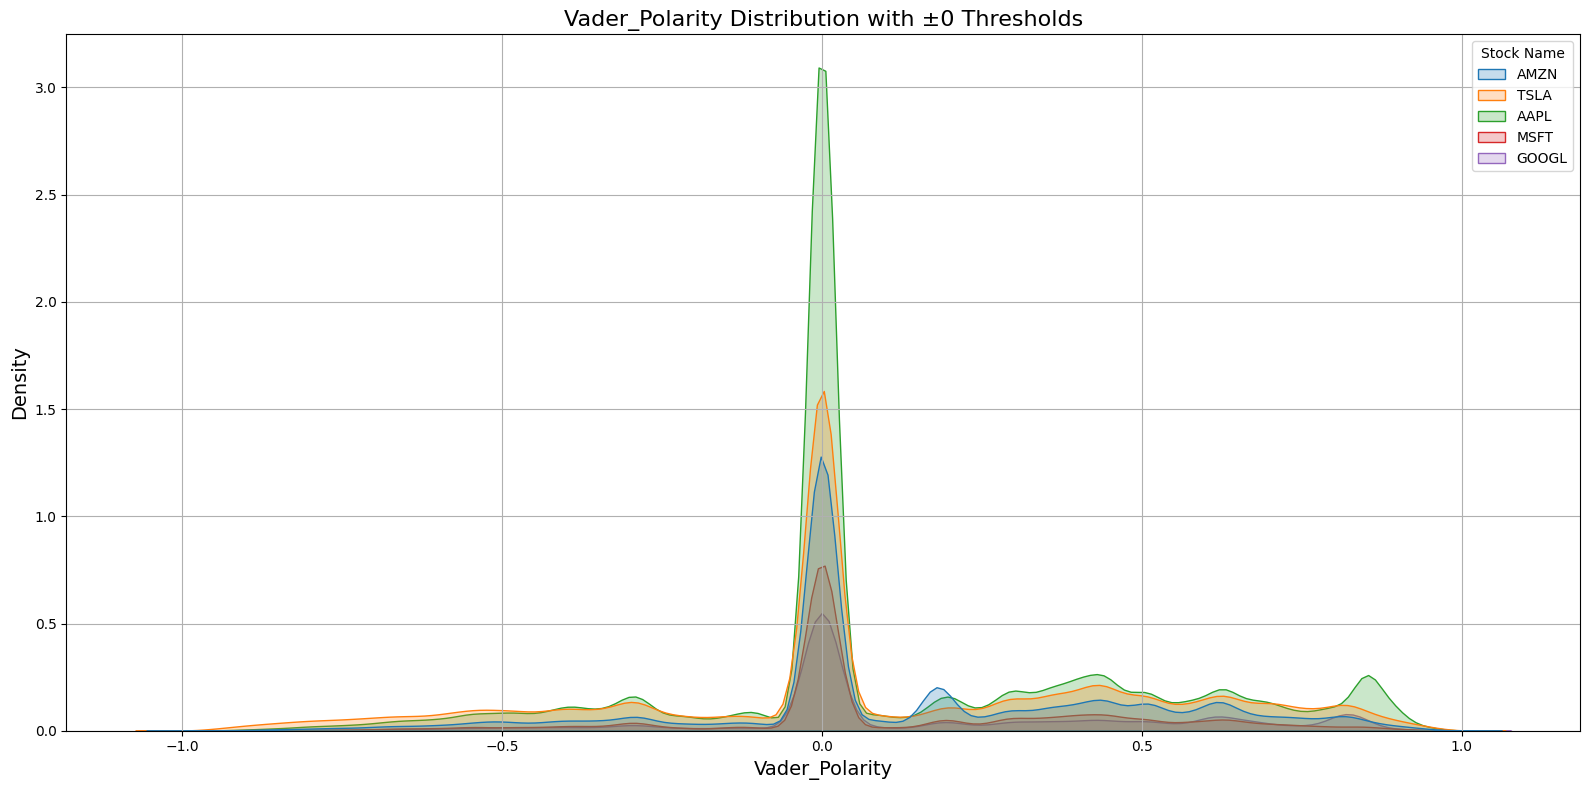

In [26]:
plot_kde(tweets_sent, polarity_col='Vader_Polarity')

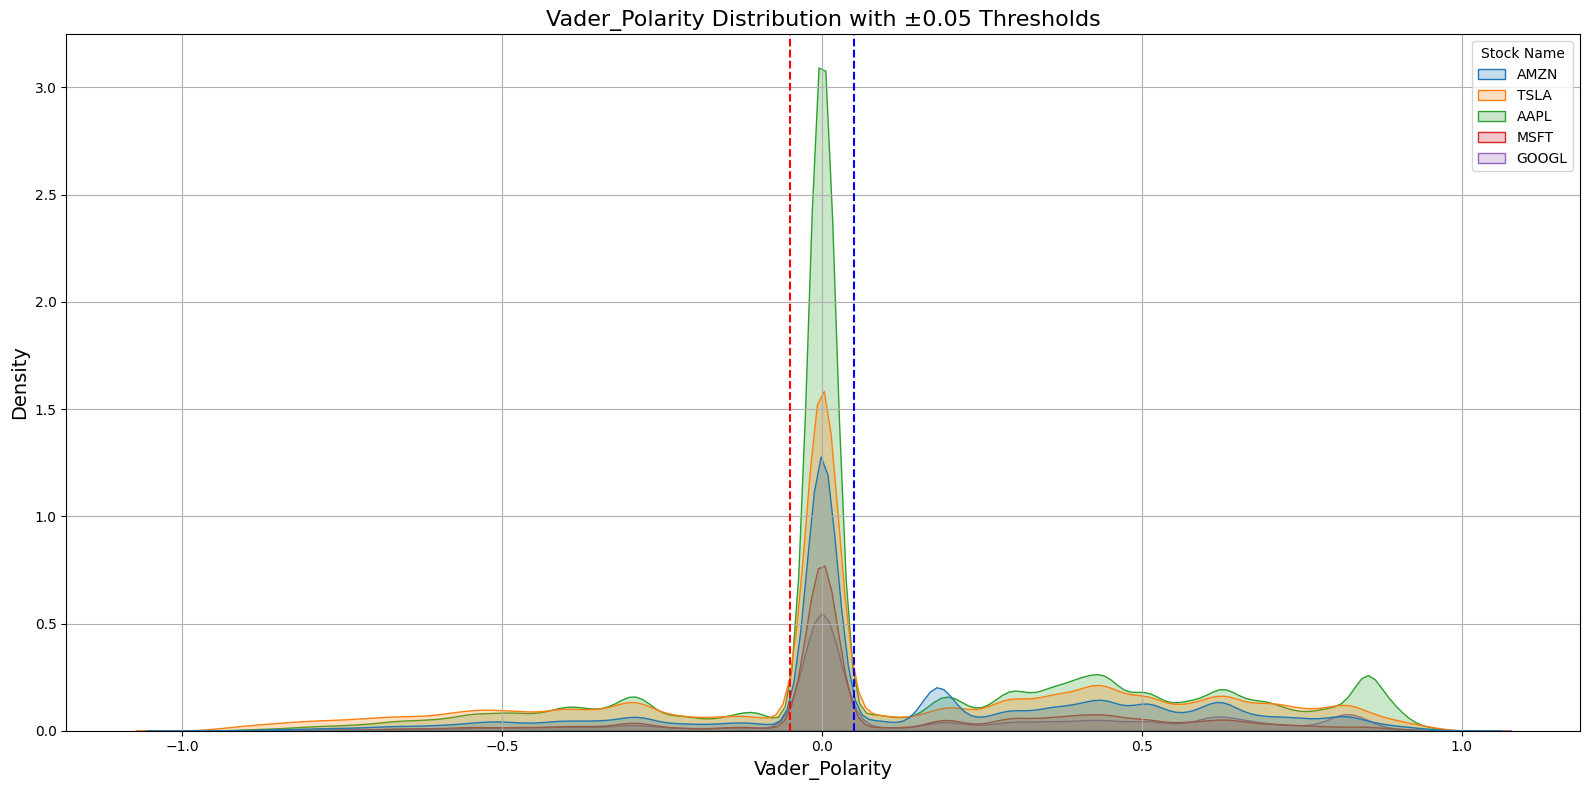

In [27]:
threshold = 0.05
plot_kde(tweets_sent, polarity_col='Vader_Polarity', threshold=threshold)

In [28]:
def polarity_filter_by_threshold(df, threshold, polarity_col='Vader_Polarity', date_col='Date', verbose=True):
   
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Apply polarity threshold filter
    filtered_df = df[
        (df[polarity_col] >= threshold) |
        (df[polarity_col] <= -threshold)
    ]

    # Compute stats
    total_dates = df[date_col].nunique()
    remaining_dates = filtered_df[date_col].nunique()
    dates_lost = total_dates - remaining_dates

    if verbose:
        print(f"-> Total unique dates before filtering: {total_dates}")
        print(f"+> Remaining unique dates after filtering: {remaining_dates}")
        print(f">> Dates lost: {dates_lost}")

    return filtered_df

In [29]:
tweets_filtered = polarity_filter_by_threshold(tweets_sent, threshold)

-> Total unique dates before filtering: 1258
+> Remaining unique dates after filtering: 1258
>> Dates lost: 0


In [30]:
def plot_daily_sentiment(df, company, sentiment_col, date_col='Date', company_col='Stock Name'):
    
    # Convert date column to datetime if needed
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Group and compute daily average sentiment
    daily_sentiment = (
        df.groupby([date_col, company_col])[sentiment_col]
        .mean()
        .reset_index(name='Avg_Sentiment')
    )

    # Filter for selected company
    company_df = daily_sentiment[daily_sentiment[company_col] == company]

    # Plot
    plt.figure(figsize=(22, 10))
    plt.plot(company_df[date_col], company_df['Avg_Sentiment'], color='blue', marker='o')
    plt.title(f"{company} - Daily Average {sentiment_col}", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Avg_Sentiment", fontsize=14)
    plt.axhline(0, color='gray', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [31]:
tweets_sent.head()

,Tweet,Stock Name,Date,Vader_Negative,Vader_Neutral,Vader_Positive,Vader_Polarity
628,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,AMZN,2015-01-02,0.000,1.000,0.000,0.0000
629,Will Audi's Electric Q7 Cause $TSLA Model X Ba...,TSLA,2015-01-02,0.000,1.000,0.000,0.0000
630,Either way you're a winnah. RT @dbbrakebill: i...,AAPL,2015-01-02,0.155,0.845,0.000,-0.3736
631,@Weeklyoptions http://Weeklyoptionplays.com we...,AAPL,2015-01-02,0.000,0.756,0.244,0.6369
632,"Cash flow machine. RT @themandotcom: $MSFT, wh...",MSFT,2015-01-02,0.000,1.000,0.000,0.0000


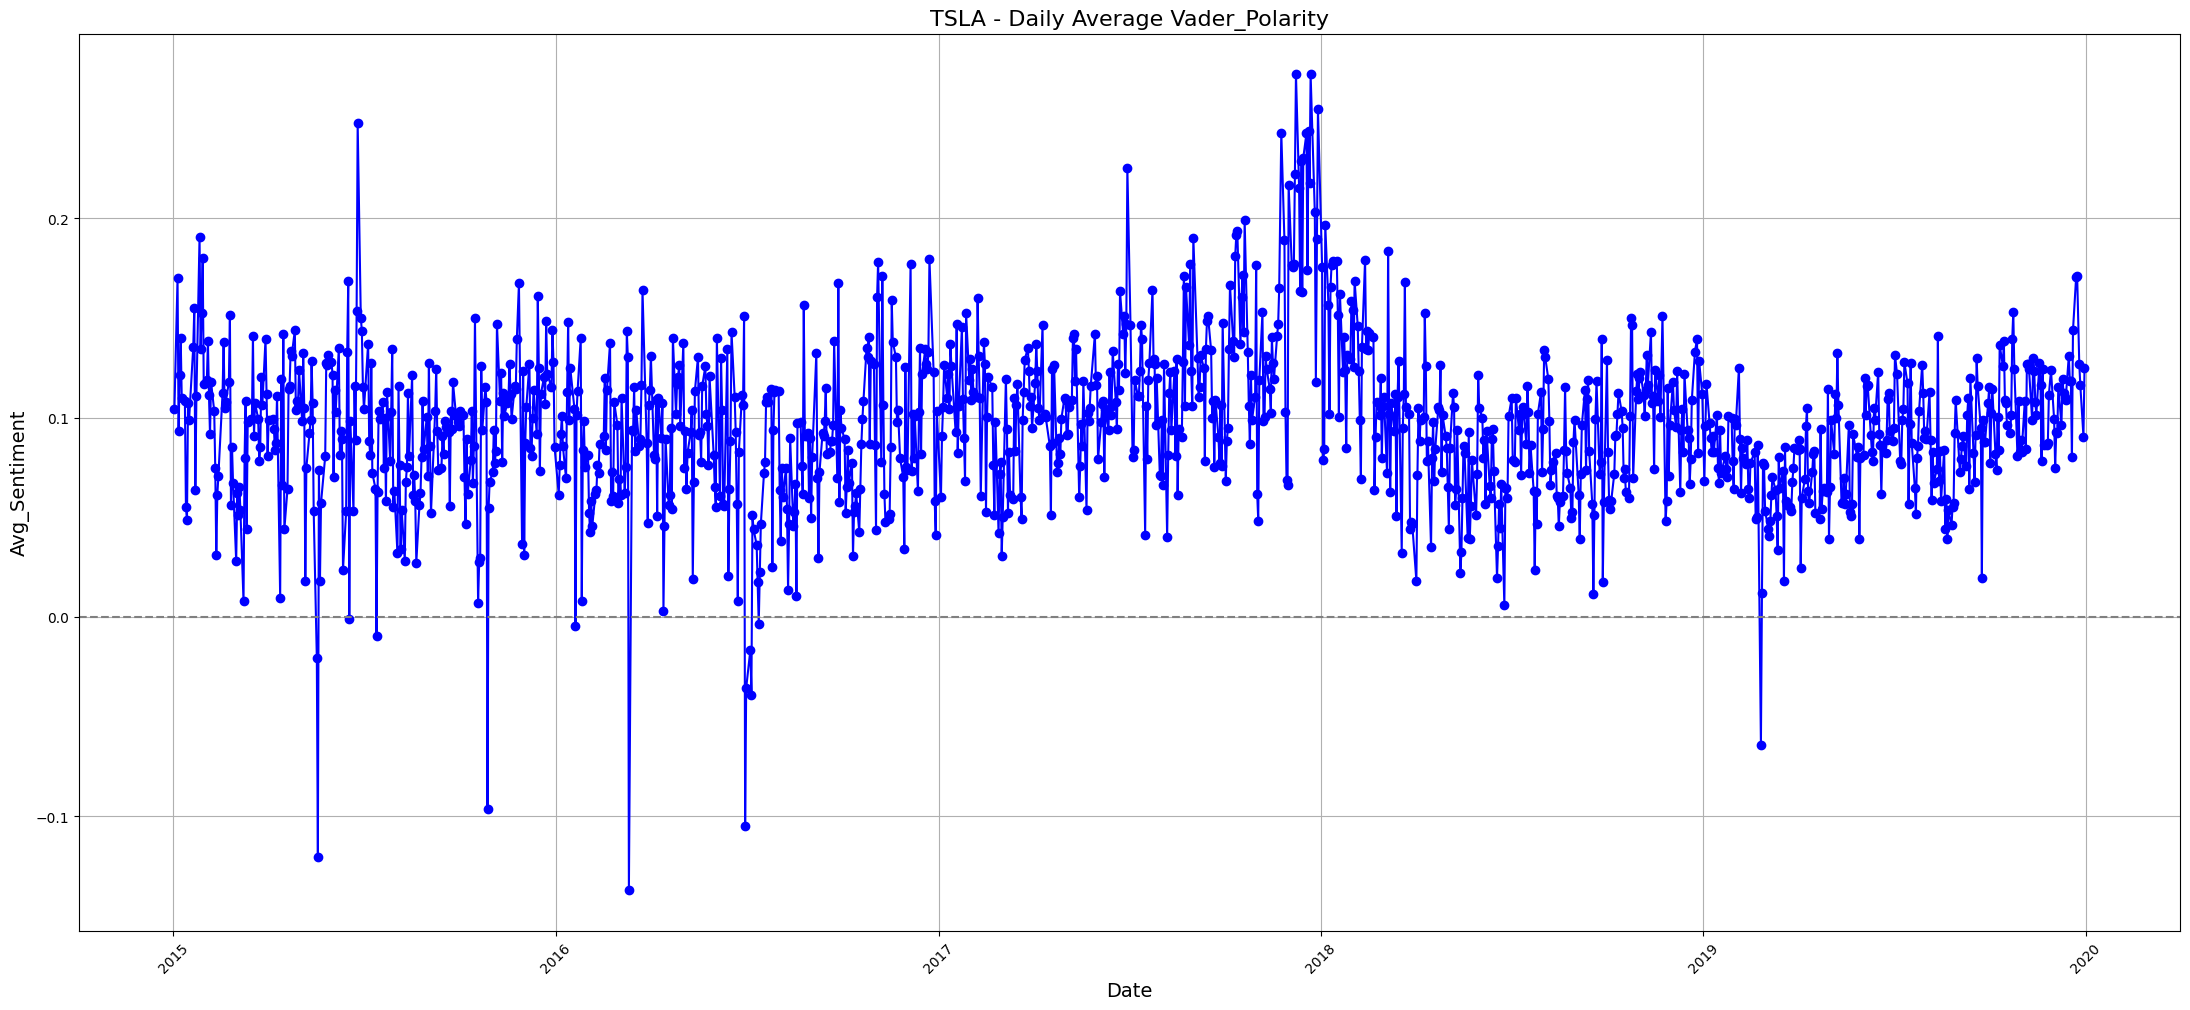

In [32]:
plot_daily_sentiment(tweets_sent, company='TSLA', sentiment_col='Vader_Polarity')

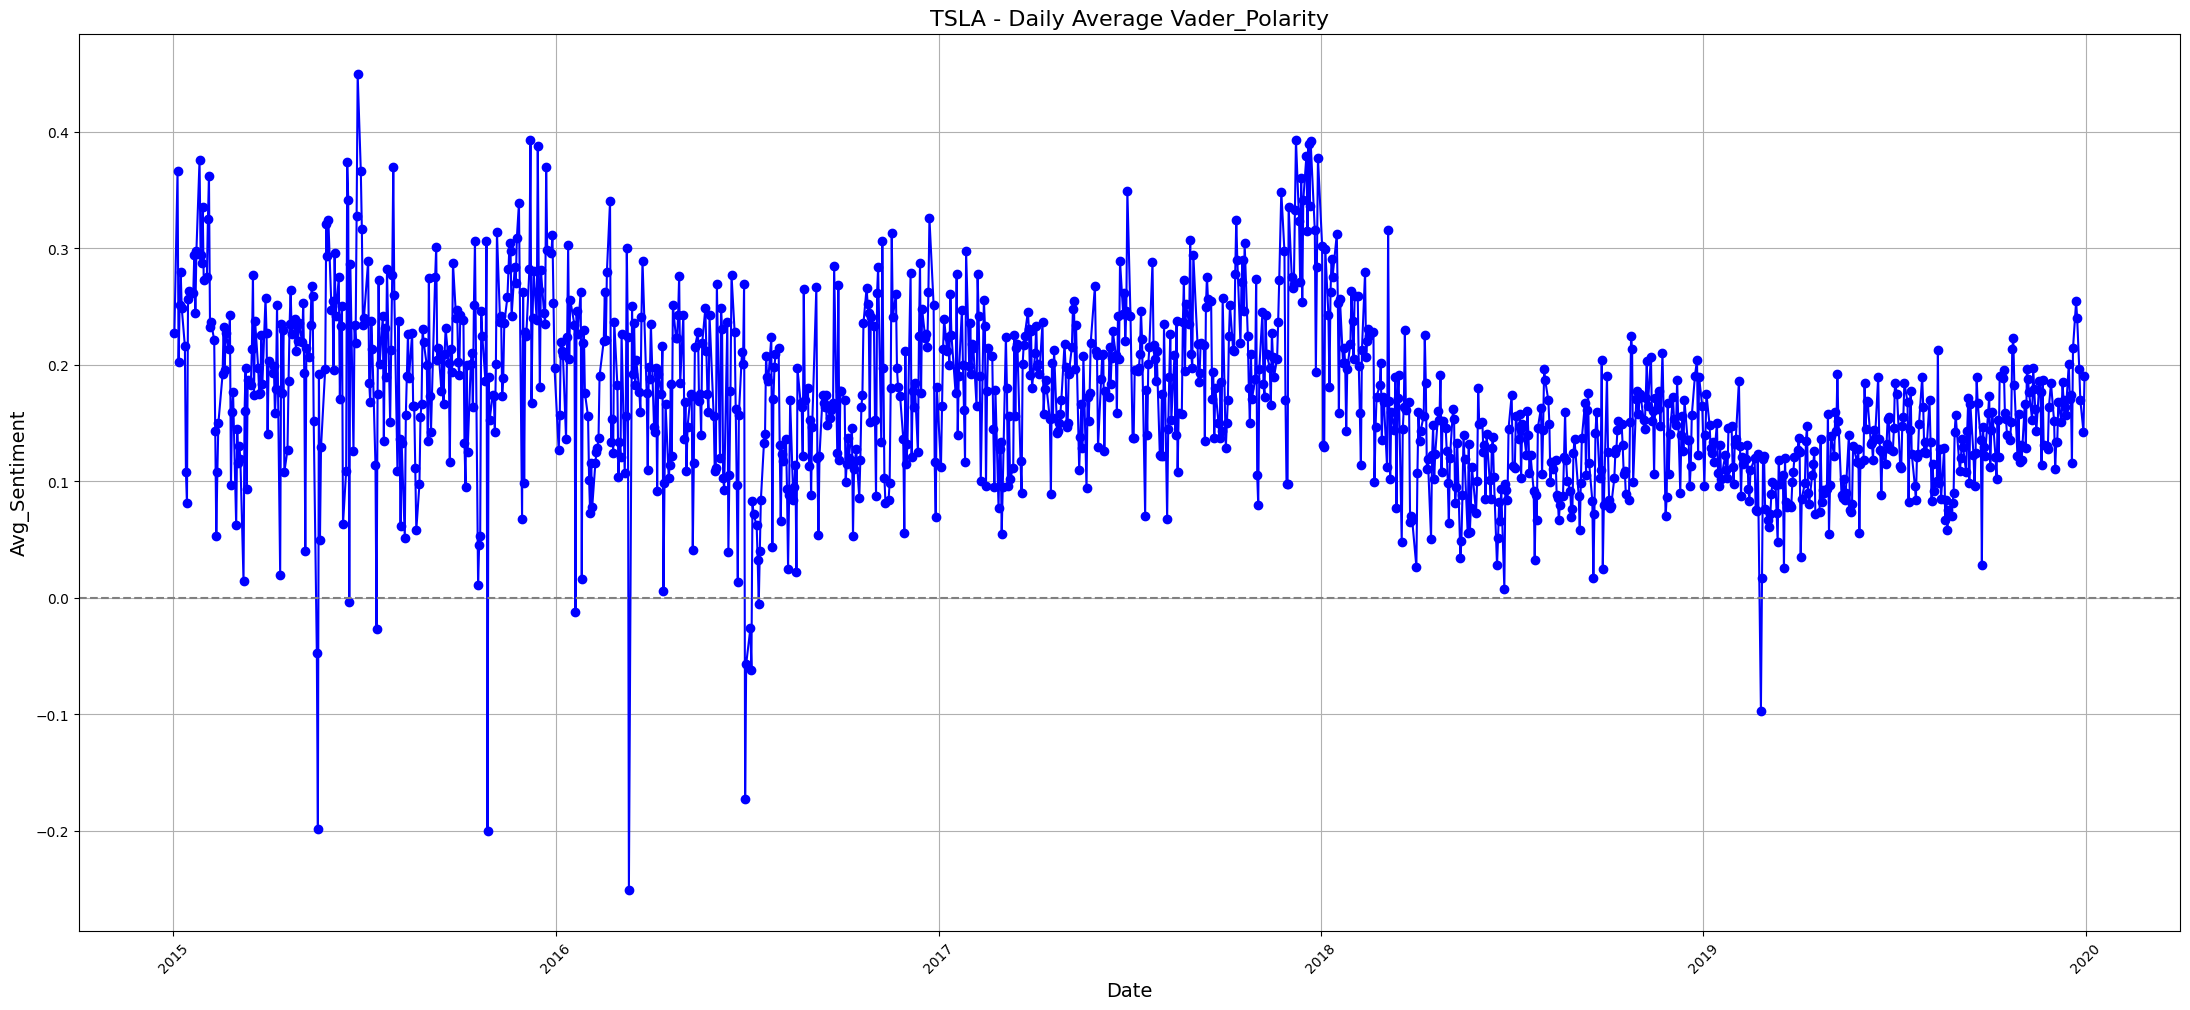

In [33]:
plot_daily_sentiment(tweets_filtered, company='TSLA', sentiment_col='Vader_Polarity')

In [34]:
tweets_filtered.head()

,Tweet,Stock Name,Date,Vader_Negative,Vader_Neutral,Vader_Positive,Vader_Polarity
630,Either way you're a winnah. RT @dbbrakebill: i...,AAPL,2015-01-02,0.155,0.845,0.000,-0.3736
631,@Weeklyoptions http://Weeklyoptionplays.com we...,AAPL,2015-01-02,0.000,0.756,0.244,0.6369
633,.@BenBajarin @counternotions @GlennF Thankful ...,AAPL,2015-01-02,0.000,0.802,0.198,0.5719
634,perfectly trading the S&P 500 in 2014 $FB $MU ...,AMZN,2015-01-02,0.000,0.781,0.219,0.6369
637,"@KyleRohde @thehilker It could be, but that's ...",AMZN,2015-01-02,0.103,0.641,0.255,0.7351


In [35]:
tweets_filtered.to_csv("./data/filtered/tweets_filtered.csv", index=False)

### 2. Calculate Technical Indicators

In [36]:
# RSI Calculation
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [37]:
def get_technical_indicators(df):
    df = df.copy()
    # Trend
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()

    # Bollinger Bands
    df['BB_Mid'] = df['SMA_5']
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Mid'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Mid'] - 2 * df['BB_Std']

    # RSI
    df['RSI_14'] = calculate_rsi(df['Close'], window=14)

    # Log Return
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # OBV
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Lag Features
    df['Prev_Close'] = df['Close'].shift(1)
    df['Prev_Volume'] = df['Volume'].shift(1)

    # Time Features
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month

    # Clean
    df = df.bfill().ffill()

    return df

In [38]:
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.320429,212818400,AAPL
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.635286,257142000,AAPL
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.637505,263188400,AAPL
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,23.968958,160423600,AAPL
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.889906,237458000,AAPL


In [39]:
stocks = stocks.set_index('Date').sort_index()
stocks = get_technical_indicators(stocks)

stocks.head()

,Open,High,Low,Close,Adj Close,Volume,Stock Name,SMA_5,SMA_20,BB_Mid,BB_Std,BB_Upper,BB_Lower,RSI_14,Log_Return,OBV,Prev_Close,Prev_Volume,DayOfWeek,Month
Date,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.320429,212818400,AAPL,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,-0.625640,0.0,27.332500,212818400.0,4,1
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,TSLA,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,-0.625640,-71466000.0,27.332500,212818400.0,4,1
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.351515,26480000,GOOGL,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,0.593859,-44986000.0,14.620667,71466000.0,4,1
2015-01-02,46.660000,47.419998,46.540001,46.759998,40.072136,27913900,MSFT,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,0.568733,-17072100.0,26.477501,26480000.0,4,1
2015-01-02,15.629000,15.737500,15.348000,15.426000,15.426000,55664000,AMZN,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,-1.108974,-72736100.0,46.759998,27913900.0,4,1


### 3. Filter Company Data

In [40]:
tweets_filtered = pd.read_csv("./data/filtered/tweets_filtered.csv")

In [41]:
company_list = ['AAPL', 'AMZN', 'MSFT', 'GOOGL', 'TSLA']

In [42]:
# Filter for selected stocks
filter_tweets = tweets_filtered[tweets_filtered['Stock Name'].isin(company_list)].copy()

# Group and compute daily average sentiment
daily_sentiment = (
    filter_tweets
    .groupby(['Stock Name', 'Date'])['Vader_Polarity']
    .mean()
    .reset_index()
)

# Set Date as index (for plotting or merging)
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])
daily_sentiment = daily_sentiment.set_index('Date').sort_index()

daily_sentiment.head()

,Stock Name,Vader_Polarity
Date,,
2015-01-02,AAPL,0.276950
2015-01-02,GOOGL,0.470091
2015-01-02,TSLA,0.227755
2015-01-02,AMZN,0.222096
2015-01-02,MSFT,0.260802


In [43]:
filter_stocks = stocks[stocks['Stock Name'].isin(company_list)]
filter_stocks.head()

,Open,High,Low,Close,Adj Close,Volume,Stock Name,SMA_5,SMA_20,BB_Mid,BB_Std,BB_Upper,BB_Lower,RSI_14,Log_Return,OBV,Prev_Close,Prev_Volume,DayOfWeek,Month
Date,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.320429,212818400,AAPL,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,-0.625640,0.0,27.332500,212818400.0,4,1
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,TSLA,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,-0.625640,-71466000.0,27.332500,212818400.0,4,1
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.351515,26480000,GOOGL,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,0.593859,-44986000.0,14.620667,71466000.0,4,1
2015-01-02,46.660000,47.419998,46.540001,46.759998,40.072136,27913900,MSFT,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,0.568733,-17072100.0,26.477501,26480000.0,4,1
2015-01-02,15.629000,15.737500,15.348000,15.426000,15.426000,55664000,AMZN,26.123333,25.620192,26.123333,11.873179,49.228223,1.735509,46.167054,-1.108974,-72736100.0,46.759998,27913900.0,4,1


### 4. Merging (Stock + Sentiment)

In [44]:
def merging(company_list, filter_stocks, daily_sentiment):
    """
    Create a joined dataset of stock data and sentiment scores for a list of stock tickers.
    
    Parameters:
    -----------
    company_list : list
        List of stock ticker symbols (e.g., ['AAPL', 'MSFT', 'GOOGL'])
    filter_stocks : pandas.DataFrame
        DataFrame containing stock price data with 'Stock Name' column
    daily_sentiment : pandas.DataFrame
        DataFrame containing sentiment scores with 'Stock Name' column
        
    Returns:
    --------
    dict
        Dictionary with ticker symbols as keys and joined DataFrames as values
    """
    # Dictionary to store results
    result_dict = {}

    for company in company_list:
        stock = filter_stocks[filter_stocks['Stock Name'] == company].copy()
        ticker_sentiment = daily_sentiment[daily_sentiment['Stock Name'] == company].copy()

        # Normalize datetime index (remove time, timezone)
        stock.index = pd.to_datetime(stock.index).normalize()
        ticker_sentiment.index = pd.to_datetime(ticker_sentiment.index).normalize()

        # Perform inner join to keep only dates present in both
        joined_data = stock.join(ticker_sentiment[['Vader_Polarity']], how='inner')

        result_dict[company] = joined_data

    return result_dict

stock_data_dict = merging(company_list, filter_stocks, daily_sentiment)

In [45]:
AAPL = stock_data_dict['AAPL']

AAPL.head()

,Open,High,Low,Close,Adj Close,Volume,Stock Name,SMA_5,SMA_20,BB_Mid,...,BB_Upper,BB_Lower,RSI_14,Log_Return,OBV,Prev_Close,Prev_Volume,DayOfWeek,Month,Vader_Polarity
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.320429,212818400,AAPL,26.123333,25.620192,26.123333,...,49.228223,1.735509,46.167054,-0.625640,0.0,27.332500,212818400.0,4,1,0.276950
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.635286,257142000,AAPL,19.415400,25.620192,19.415400,...,49.228223,1.735509,46.167054,0.640015,89576400.0,14.006000,80527500.0,0,1,0.251420
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.637505,263188400,AAPL,31.822701,25.620192,31.822701,...,49.228223,1.735509,46.167054,-0.541409,-170386000.0,45.650002,36447900.0,1,1,0.281760
2015-01-07,26.799999,27.049999,26.674999,26.937500,23.968958,160423600,AAPL,27.564067,25.620192,27.564067,...,49.228223,1.735509,53.500699,0.649948,-41384800.0,14.063333,44526000.0,2,1,0.271373
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.889906,237458000,AAPL,19.783466,25.672308,19.783466,...,43.502581,-3.935649,54.182309,0.621640,205035200.0,15.023000,61768000.0,3,1,0.321796


In [46]:
for company in company_list:
    df = stock_data_dict[company]
    df.to_csv(f"./data/filtered/{company}_filtered.csv", index=True)

### 5. Visualizing Related Features

In [47]:
company_list = ['TSLA', 'AAPL', 'AMZN', 'GOOGL']
stock_data_dict = {}

for symbol in company_list:
    path = f"./data/filtered/{symbol}_filtered.csv"
    stock_data_dict[symbol] = pd.read_csv(path)

In [48]:
tweets_filtered = pd.read_csv("./data/filtered/tweets_filtered.csv")

In [49]:
TSLA = stock_data_dict['TSLA']
TSLA.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,SMA_5,SMA_20,...,BB_Upper,BB_Lower,RSI_14,Log_Return,OBV,Prev_Close,Prev_Volume,DayOfWeek,Month,Vader_Polarity
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,TSLA,26.123333,25.620192,...,49.228223,1.735509,46.167054,-0.625640,-71466000.0,27.332500,212818400.0,4,1,0.227755
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,TSLA,23.454899,25.620192,...,49.228223,1.735509,46.167054,-0.075838,-167565600.0,15.109500,55484000.0,0,1,0.366453
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500,TSLA,31.838567,25.620192,...,49.228223,1.735509,46.167054,-0.634461,-264314500.0,26.565001,263188400.0,1,1,0.202426
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000,TSLA,25.129466,25.620192,...,49.228223,1.735509,41.060477,-1.190058,-201808400.0,46.230000,29114100.0,2,1,0.251155
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500,TSLA,25.994467,25.587975,...,50.001643,1.987290,41.785148,-1.220617,109988900.0,47.590000,29645200.0,3,1,0.279833


In [50]:
# Combine all stock DataFrames into one
stocks = pd.concat(stock_data_dict.values(), ignore_index=True)

# 将日期列转为 datetime 类型，并排序
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks.sort_values(['Date', 'Stock Name']).reset_index(drop=True)

print(stocks['Stock Name'].value_counts())

Stock Name
AMZN     1258
GOOGL    1258
TSLA     1258
AAPL     1255
Name: count, dtype: int64


In [51]:
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,SMA_5,SMA_20,...,BB_Upper,BB_Lower,RSI_14,Log_Return,OBV,Prev_Close,Prev_Volume,DayOfWeek,Month,Vader_Polarity
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.320429,212818400,AAPL,26.123333,25.620192,...,49.228223,1.735509,46.167054,-0.625640,0.0,27.332500,212818400.0,4,1,0.276950
1,2015-01-02,15.629000,15.737500,15.348000,15.426000,15.426000,55664000,AMZN,26.123333,25.620192,...,49.228223,1.735509,46.167054,-1.108974,-72736100.0,46.759998,27913900.0,4,1,0.222096
2,2015-01-02,26.629999,26.790001,26.393999,26.477501,26.351515,26480000,GOOGL,26.123333,25.620192,...,49.228223,1.735509,46.167054,0.593859,-44986000.0,14.620667,71466000.0,4,1,0.470091
3,2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,TSLA,26.123333,25.620192,...,49.228223,1.735509,46.167054,-0.625640,-71466000.0,27.332500,212818400.0,4,1,0.227755
4,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.635286,257142000,AAPL,19.415400,25.620192,...,49.228223,1.735509,46.167054,0.640015,89576400.0,14.006000,80527500.0,0,1,0.251420


In [52]:
stocks['Date'].unique().value_counts()

2015-01-02    1
2015-01-05    1
2015-01-06    1
2015-01-07    1
2015-01-08    1
             ..
2019-12-24    1
2019-12-26    1
2019-12-27    1
2019-12-30    1
2019-12-31    1
Name: count, Length: 1258, dtype: int64

In [53]:
def plot_price_sma_grid(df_all, company_list):
    fig, axs = plt.subplots(2, 2, figsize=(21, 12))  # 14x6 per plot
    axs = axs.flatten()

    for i, company in enumerate(company_list):
        df = df_all[df_all['Stock Name'] == company]
        axs[i].plot(df['Date'], df['Close'], label='Close', color='black')
        axs[i].plot(df['Date'], df['SMA_5'], label='SMA 5', color='red')
        axs[i].set_title(f'{company} – Closing Price vs SMA 5')
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

def plot_log_return_grid(df_all, company_list):
    fig, axs = plt.subplots(2, 2, figsize=(21, 12))
    axs = axs.flatten()

    for i, company in enumerate(company_list):
        df = df_all[df_all['Stock Name'] == company]
        axs[i].plot(df['Date'], df['Log_Return'], color='orange')
        axs[i].set_title(f'{company} – Daily Log Return')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

def plot_rsi_grid(df_all, company_list):
    fig, axs = plt.subplots(2, 2, figsize=(21, 12))
    axs = axs.flatten()

    for i, company in enumerate(company_list):
        df = df_all[df_all['Stock Name'] == company]
        axs[i].plot(df['Date'], df['RSI_14'], color='purple')
        axs[i].axhline(70, color='red', linestyle='--')
        axs[i].axhline(30, color='green', linestyle='--')
        axs[i].set_title(f'{company} – RSI (14-day)')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

def plot_volume_grid(df_all, company_list):
    fig, axs = plt.subplots(2, 2, figsize=(21, 12))
    axs = axs.flatten()

    for i, company in enumerate(company_list):
        df = df_all[df_all['Stock Name'] == company]
        axs[i].plot(df['Date'], df['Volume'], color='gray')
        axs[i].set_title(f'{company} – Daily Trading Volume')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

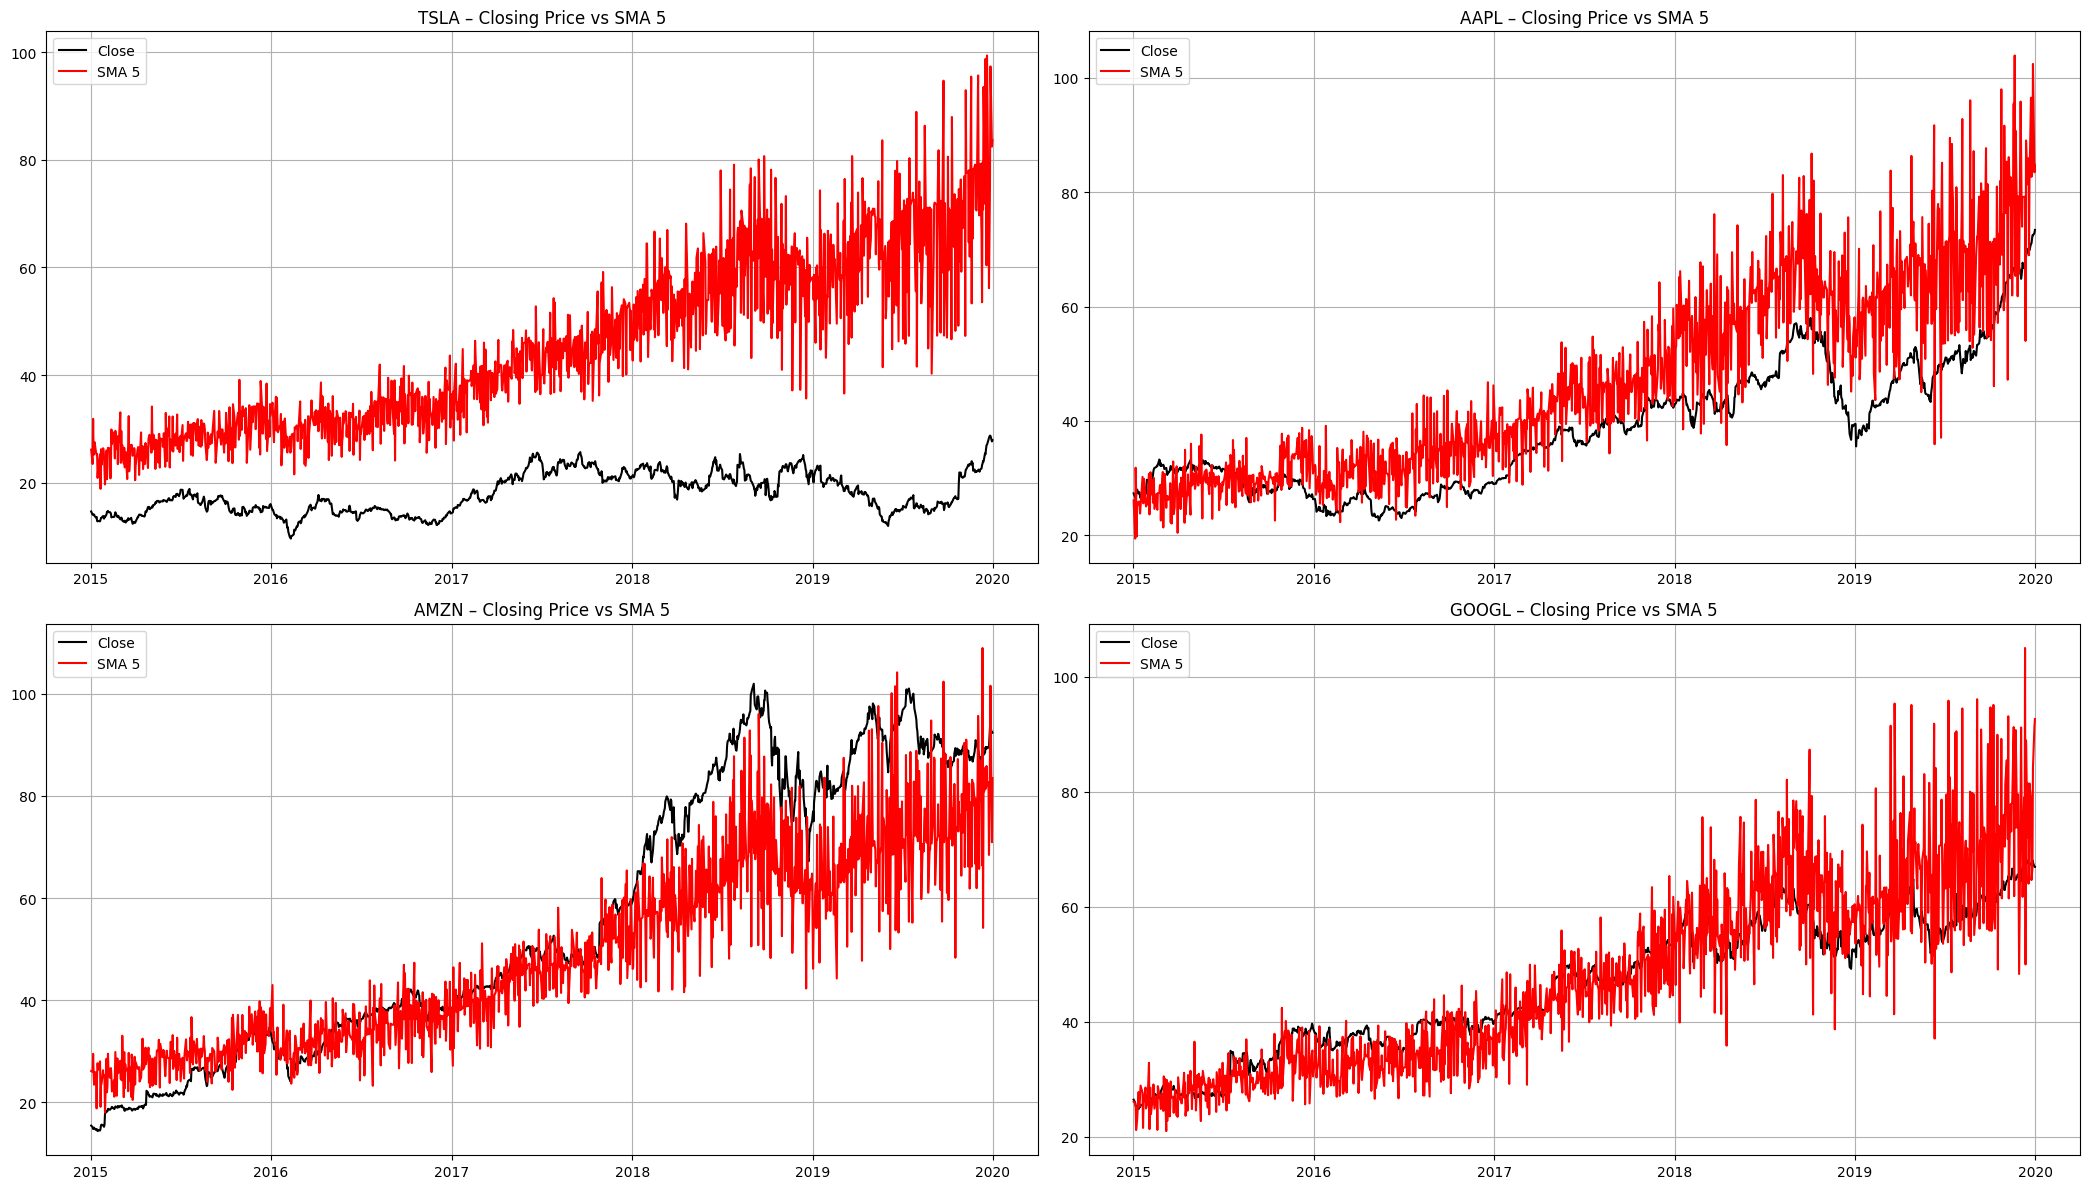

In [54]:
plot_price_sma_grid(stocks, company_list)

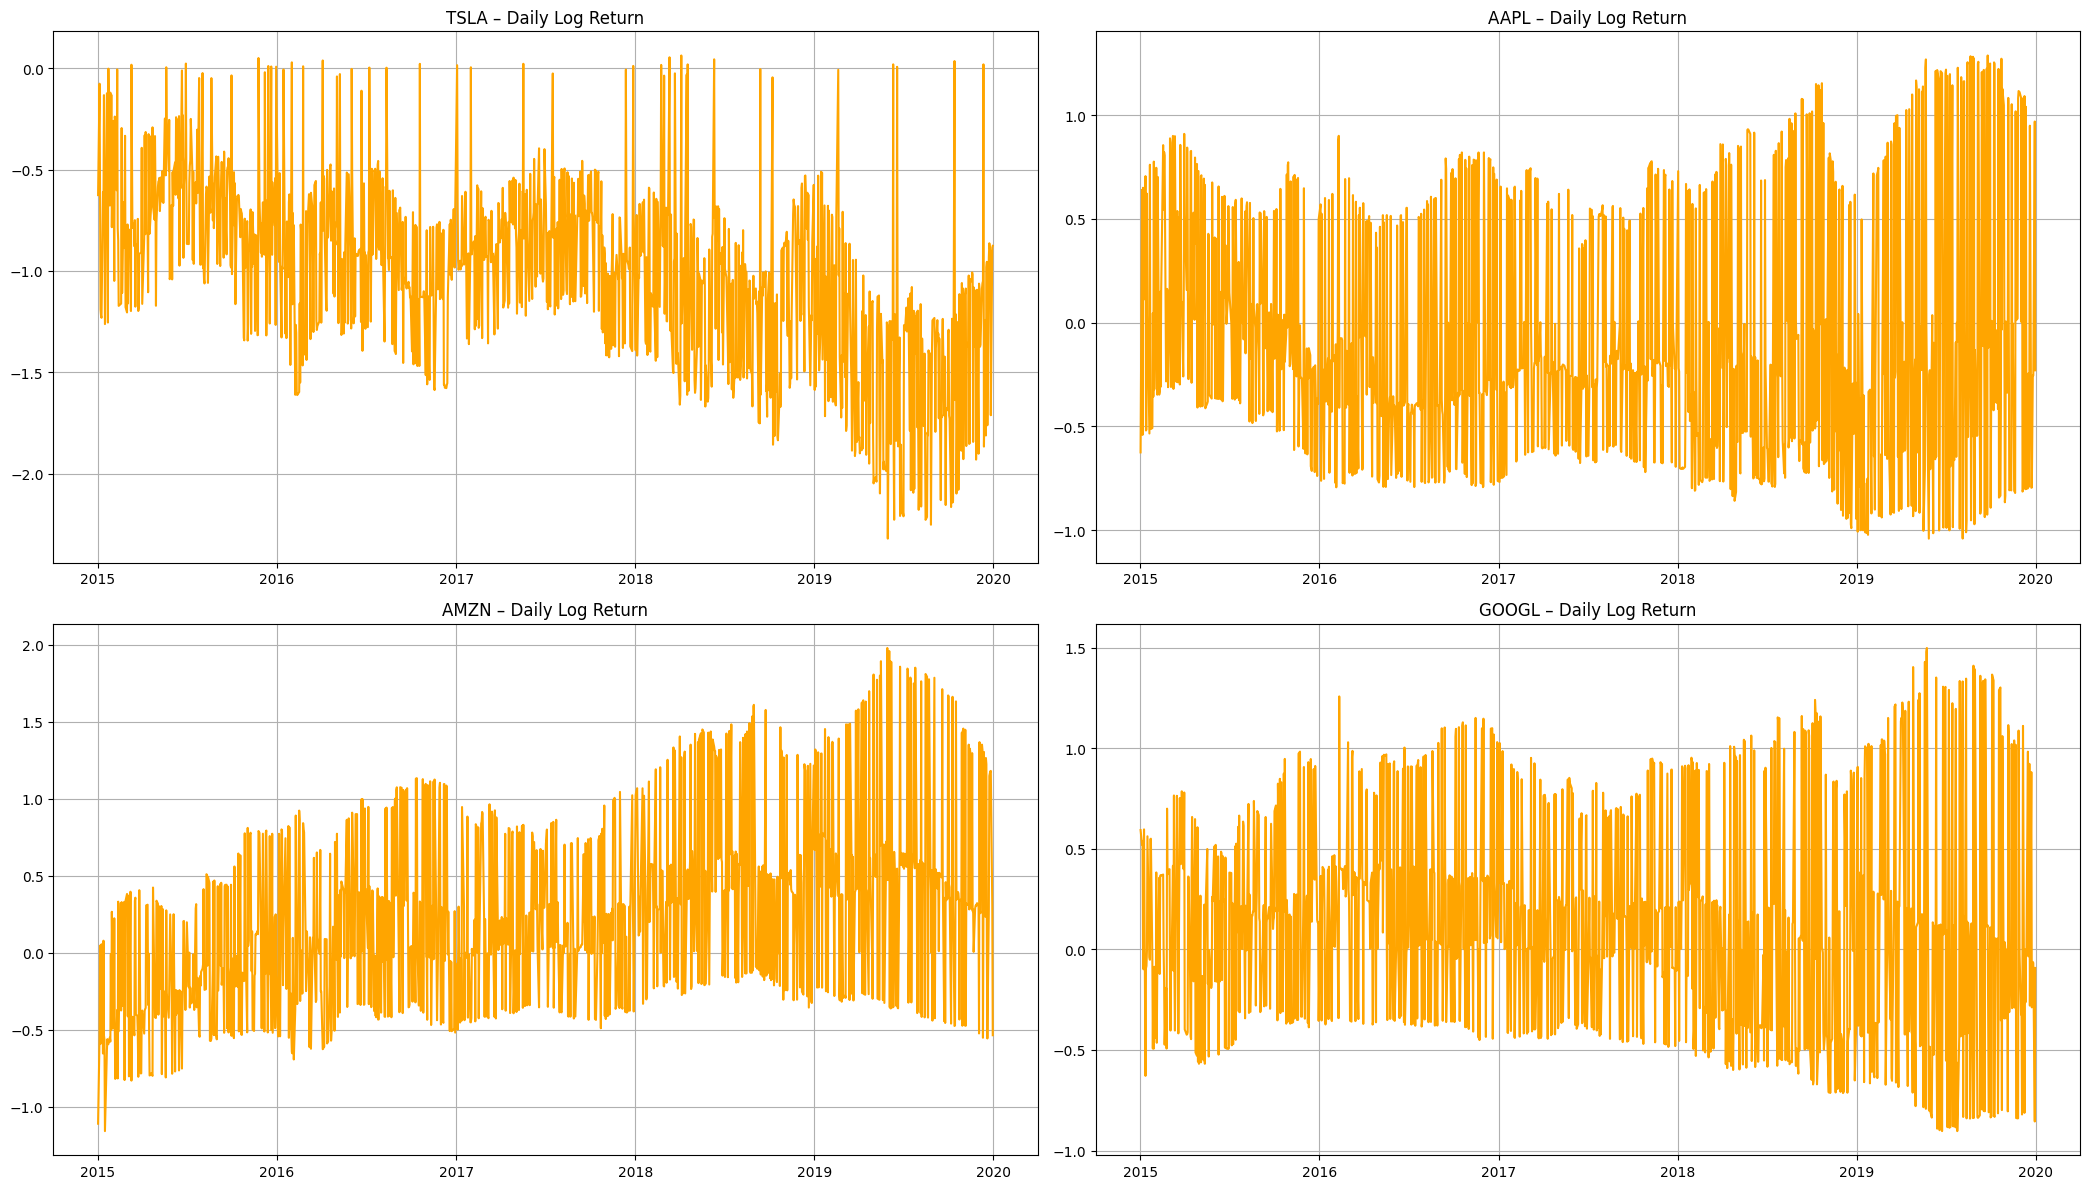

In [55]:
plot_log_return_grid(stocks, company_list)

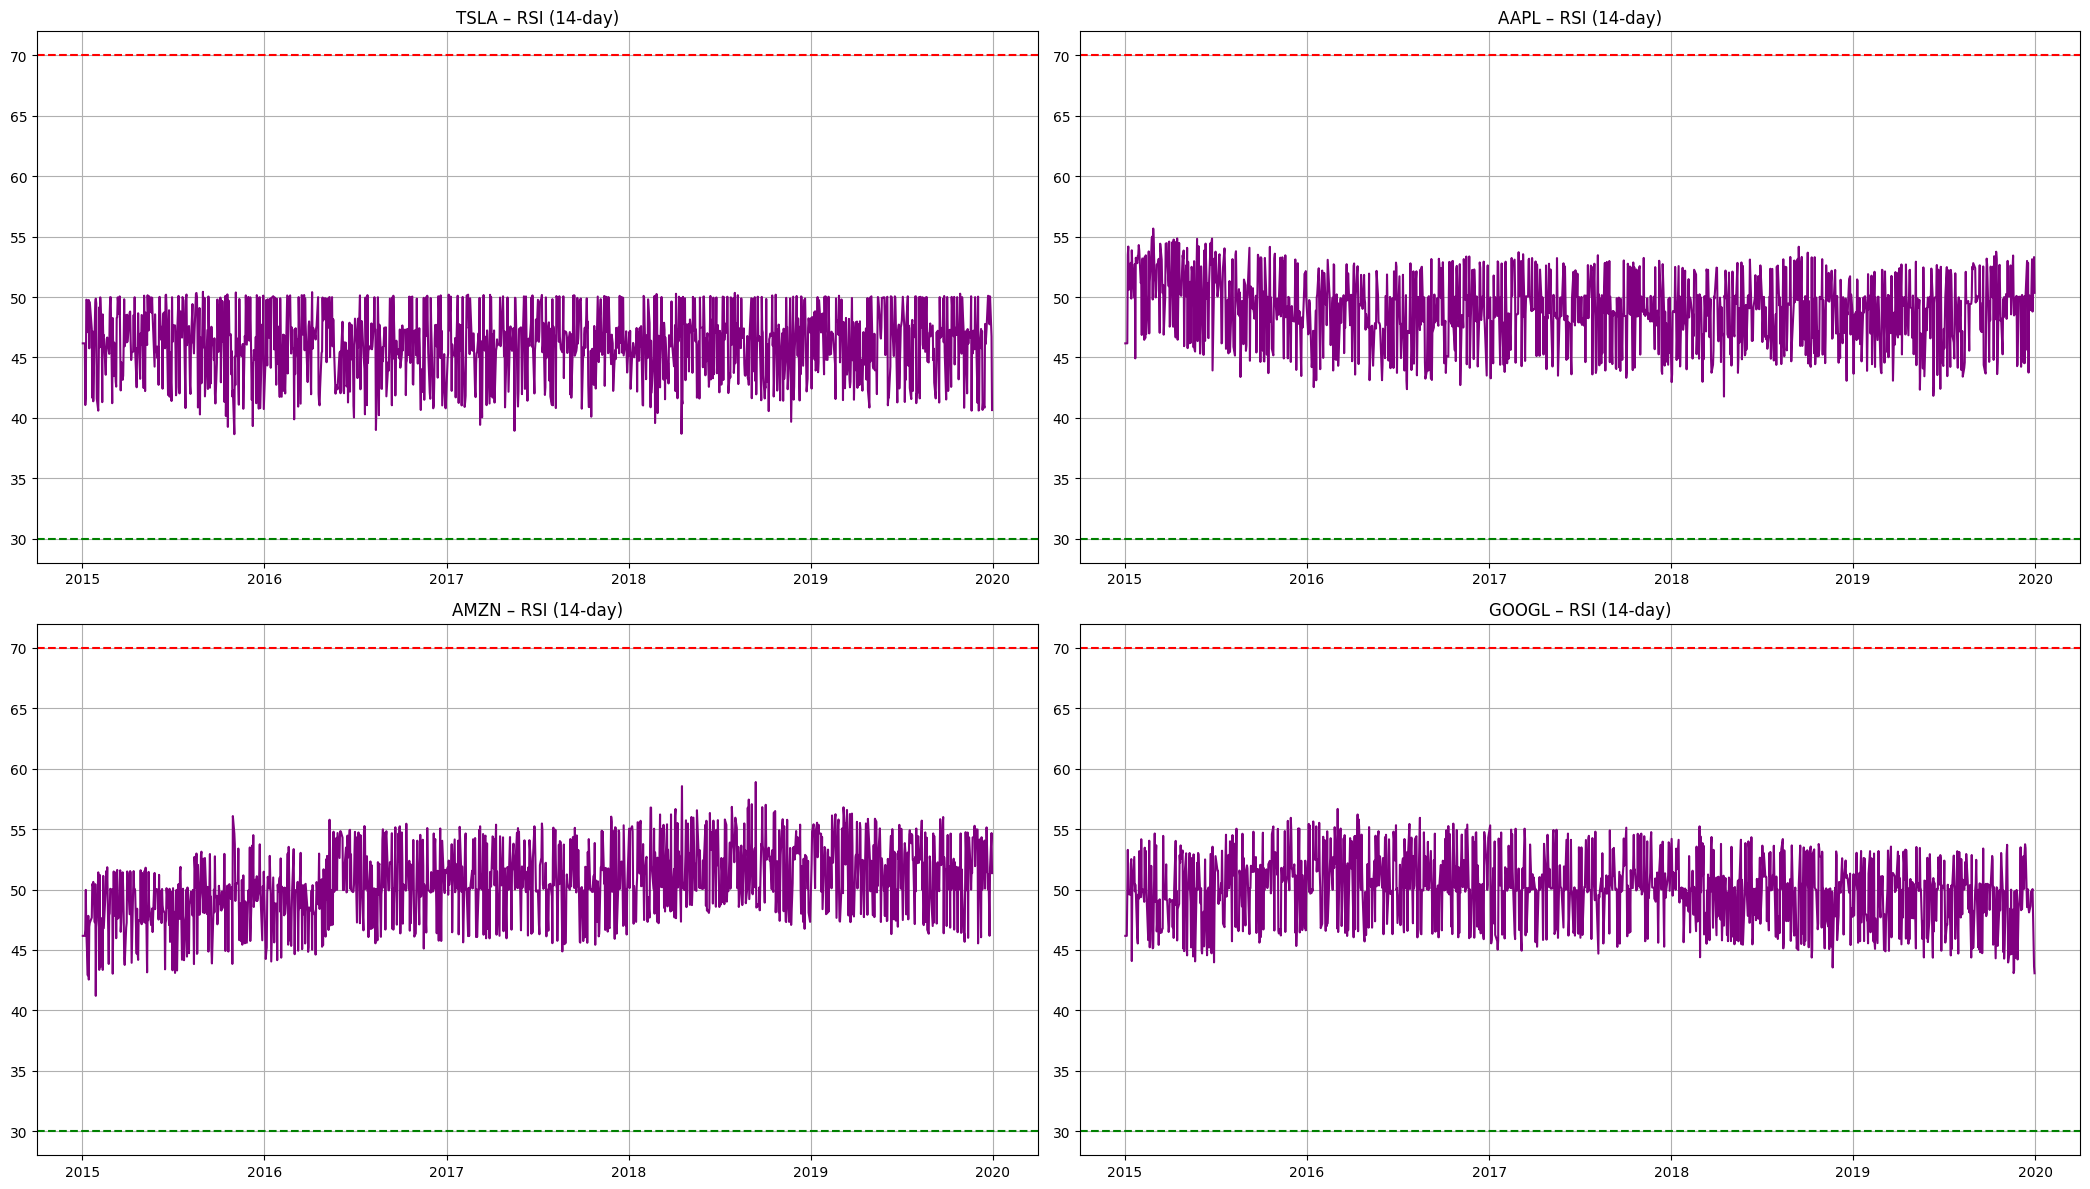

In [56]:
plot_rsi_grid(stocks, company_list)

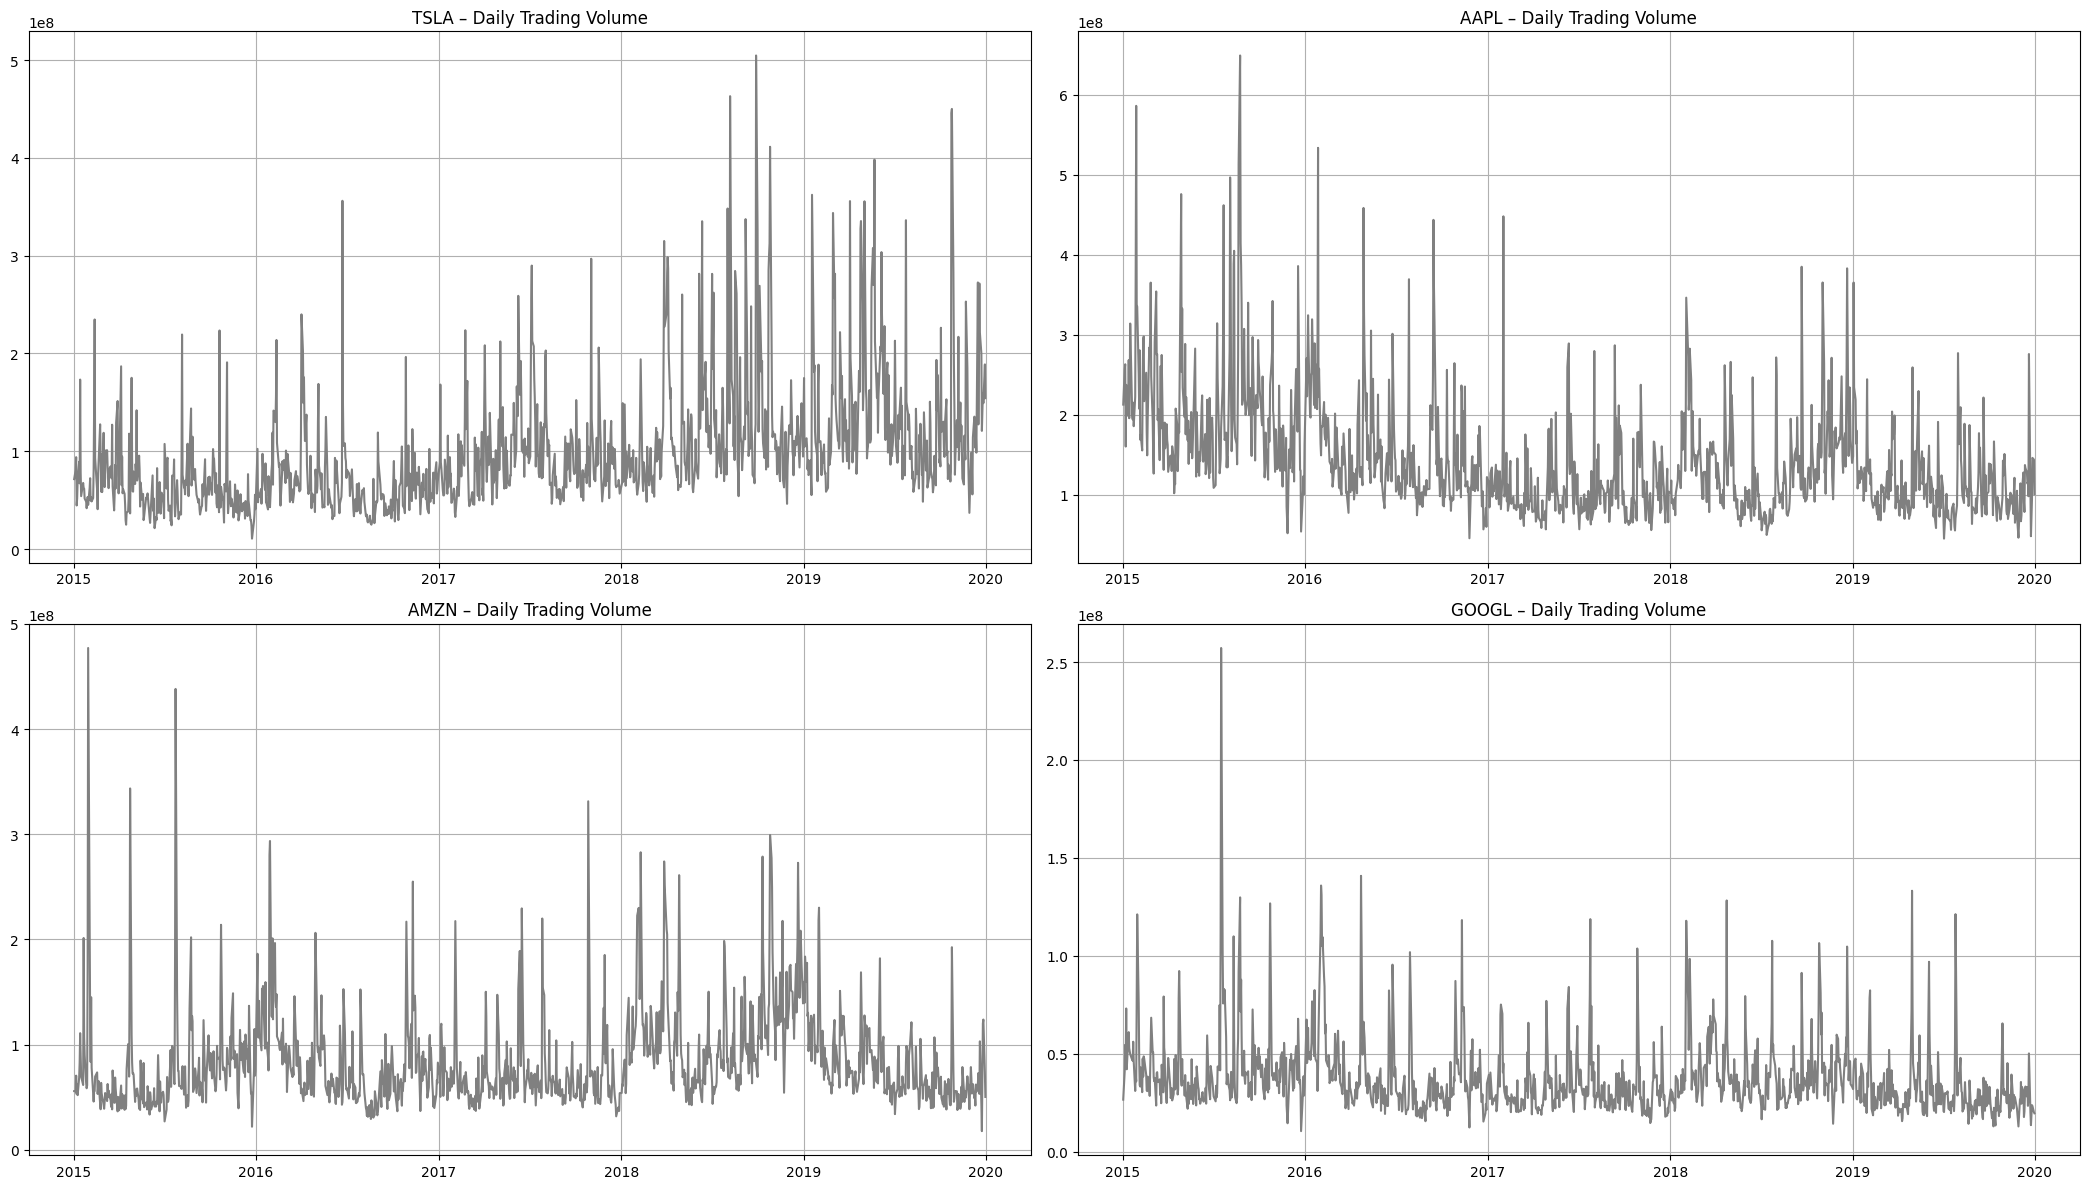

In [57]:
plot_volume_grid(stocks, company_list)

In [58]:
def plot_price_vs_sentiment(df_all, company_list, sentiment_col='Vader_Polarity'):
    fig, axs = plt.subplots(2, 2, figsize=(21, 12))  # Grid for 4 companies
    axs = axs.flatten()

    for i, company in enumerate(company_list):
        df = df_all[df_all['Stock Name'] == company]
        ax1 = axs[i]

        # Left y-axis: Close Price
        ax1.plot(df['Date'], df['Close'], color='black', linestyle='--', label='Close')
        ax1.set_ylabel('Close Price ($)', color='black', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True)  # 避免重复网格线

        # Twin y-axis for sentiment
        ax2 = ax1.twinx()
        ax2.plot(df['Date'], df[sentiment_col], color='orange', label=sentiment_col)
        ax2.set_ylabel(sentiment_col, color='orange', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='orange')
        ax2.grid(False)  # 避免重复网格线

        # Title and grid
        ax1.set_title(f'{company} – Close vs {sentiment_col}', fontsize=14)
        ax1.set_xlabel('Date')

    plt.tight_layout()
    plt.show()

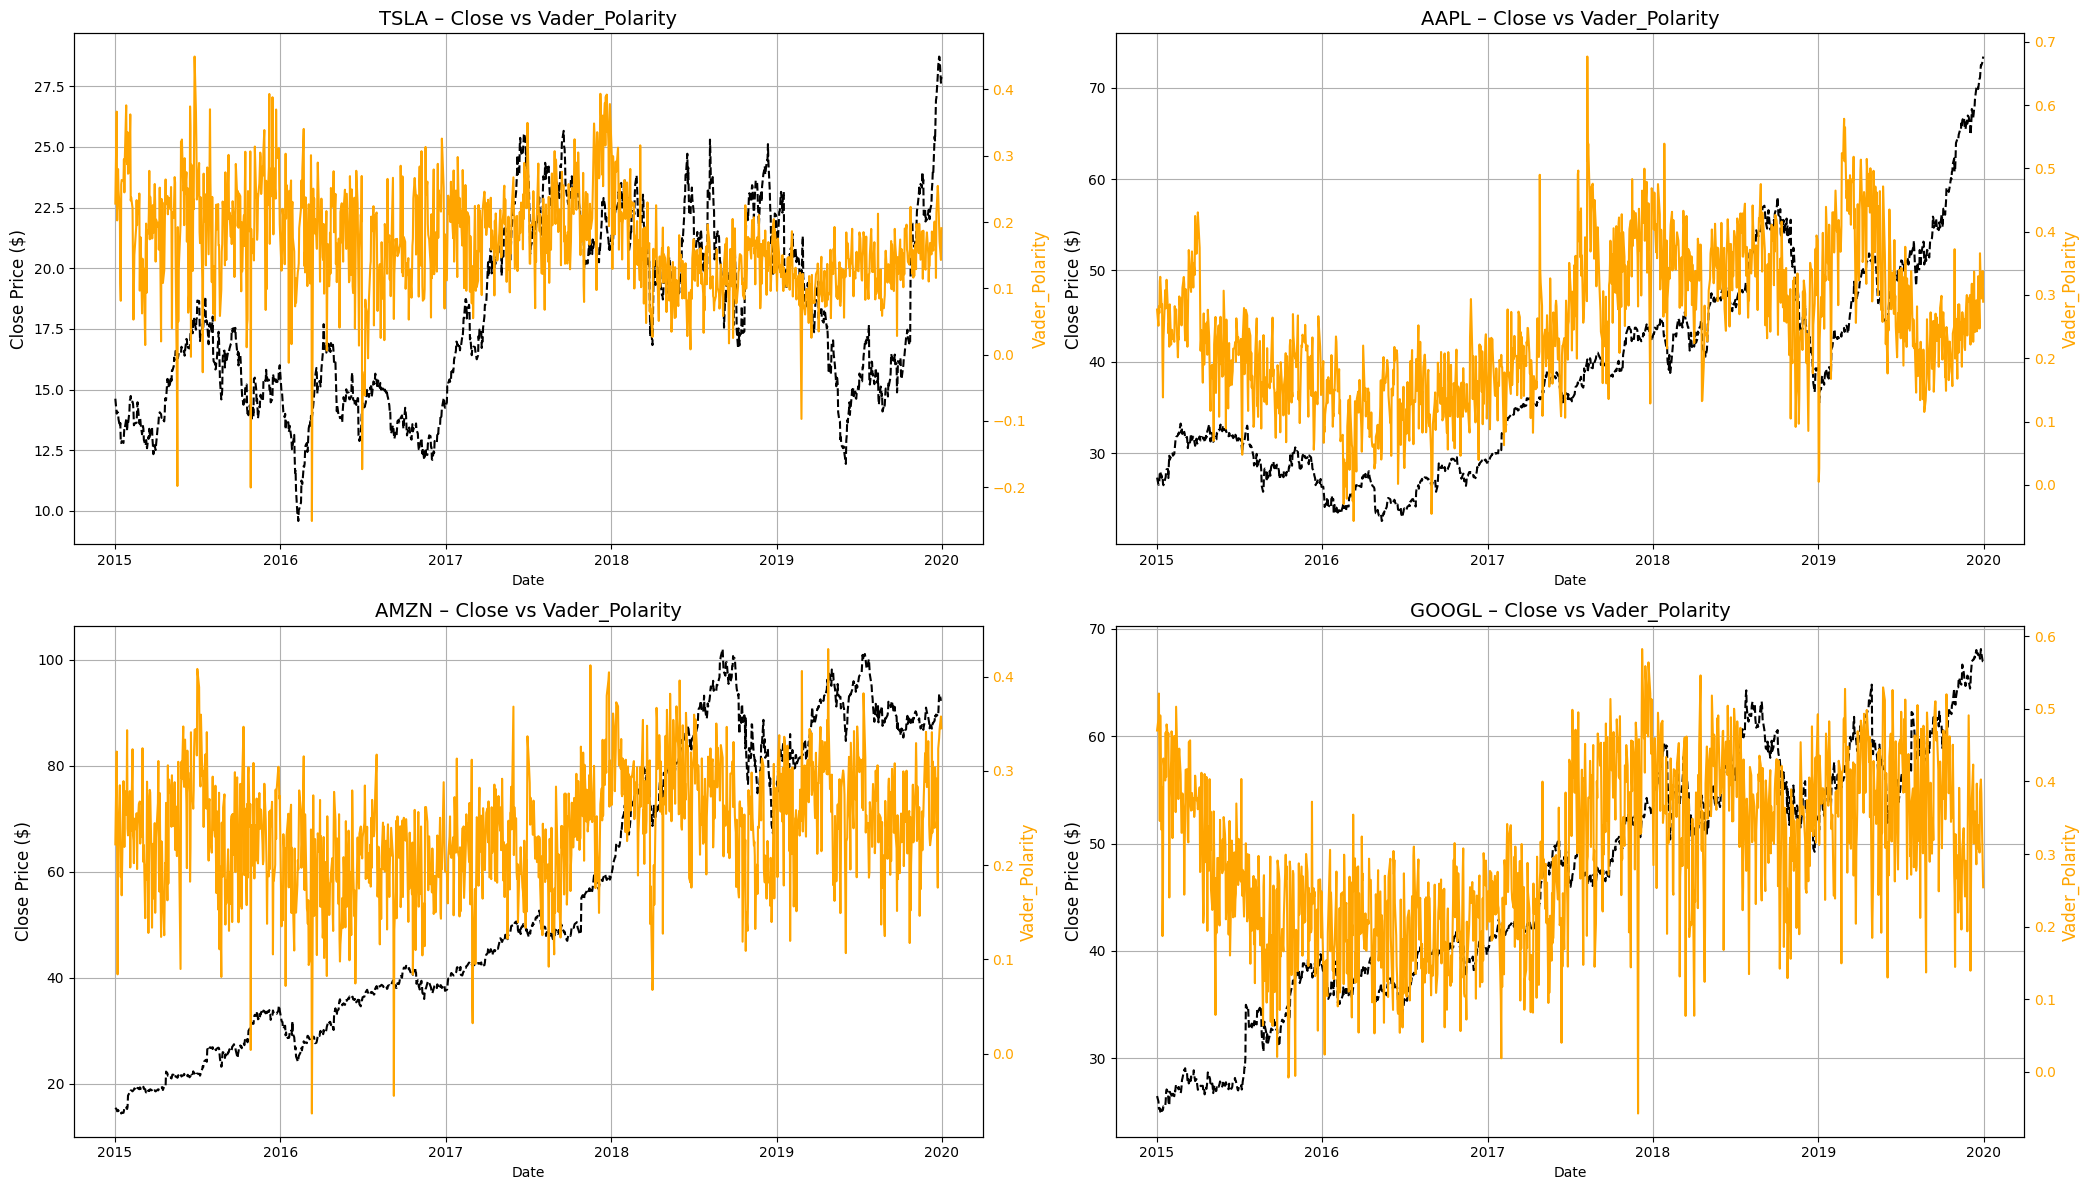

In [59]:
plot_price_vs_sentiment(stocks, company_list, sentiment_col='Vader_Polarity')

## Feature Selection

In [60]:
TSLA = stock_data_dict['TSLA']
df = TSLA.copy()

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,SMA_5,SMA_20,...,BB_Upper,BB_Lower,RSI_14,Log_Return,OBV,Prev_Close,Prev_Volume,DayOfWeek,Month,Vader_Polarity
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,TSLA,26.123333,25.620192,...,49.228223,1.735509,46.167054,-0.625640,-71466000.0,27.332500,212818400.0,4,1,0.227755
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,TSLA,23.454899,25.620192,...,49.228223,1.735509,46.167054,-0.075838,-167565600.0,15.109500,55484000.0,0,1,0.366453
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500,TSLA,31.838567,25.620192,...,49.228223,1.735509,46.167054,-0.634461,-264314500.0,26.565001,263188400.0,1,1,0.202426
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000,TSLA,25.129466,25.620192,...,49.228223,1.735509,41.060477,-1.190058,-201808400.0,46.230000,29114100.0,2,1,0.251155
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500,TSLA,25.994467,25.587975,...,50.001643,1.987290,41.785148,-1.220617,109988900.0,47.590000,29645200.0,3,1,0.279833


In [61]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Stock Name', 'SMA_5', 'SMA_20', 'BB_Mid', 'BB_Std', 'BB_Upper',
       'BB_Lower', 'RSI_14', 'Log_Return', 'OBV', 'Prev_Close', 'Prev_Volume',
       'DayOfWeek', 'Month', 'Vader_Polarity'],
      dtype='object')

### 1. Avoid Data Leakage

In [62]:
# Lag technical indicators to avoid leakage
lag_cols = [
    'Adj Close', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_20',
    'BB_Mid', 'BB_Std', 'BB_Upper', 'BB_Lower',
    'RSI_14', 'Log_Return', 'OBV', 'Vader_Polarity'
]

for col in lag_cols:
    if col == "Adj Close":
        df[f"{col} (lag1)"] = df[col].shift(1)
    else:
        df[col] = df[col].shift(1)

feature_cols = [
    'Adj Close',
    'Open', 'High', 'Low', 'Volume', 'Adj Close (lag1)',
    'SMA_5', 'SMA_20', 'BB_Mid', 'BB_Upper', 'BB_Lower',
    'OBV', 'Log_Return', 'DayOfWeek', 'Month',
    'Vader_Polarity'
]

df = df[feature_cols]

In [63]:
feature_cols = [
    'Adj Close',               # 当前天的 Adj Close ➤ ❌ 必须移除（泄漏）
    'Open', 'High', 'Low', 'Volume', 
    'Adj Close (lag1)',        # ✅ 昨天的收盘价，合法
    'SMA_5', 'SMA_20', 'BB_Mid', 'BB_Upper', 'BB_Lower',
    'OBV', 'Log_Return', 'DayOfWeek', 'Month',
    'Vader_Polarity'
]

target_col = 'Adj Close'  # or 'Log_Return'

### 2. Feature Importance

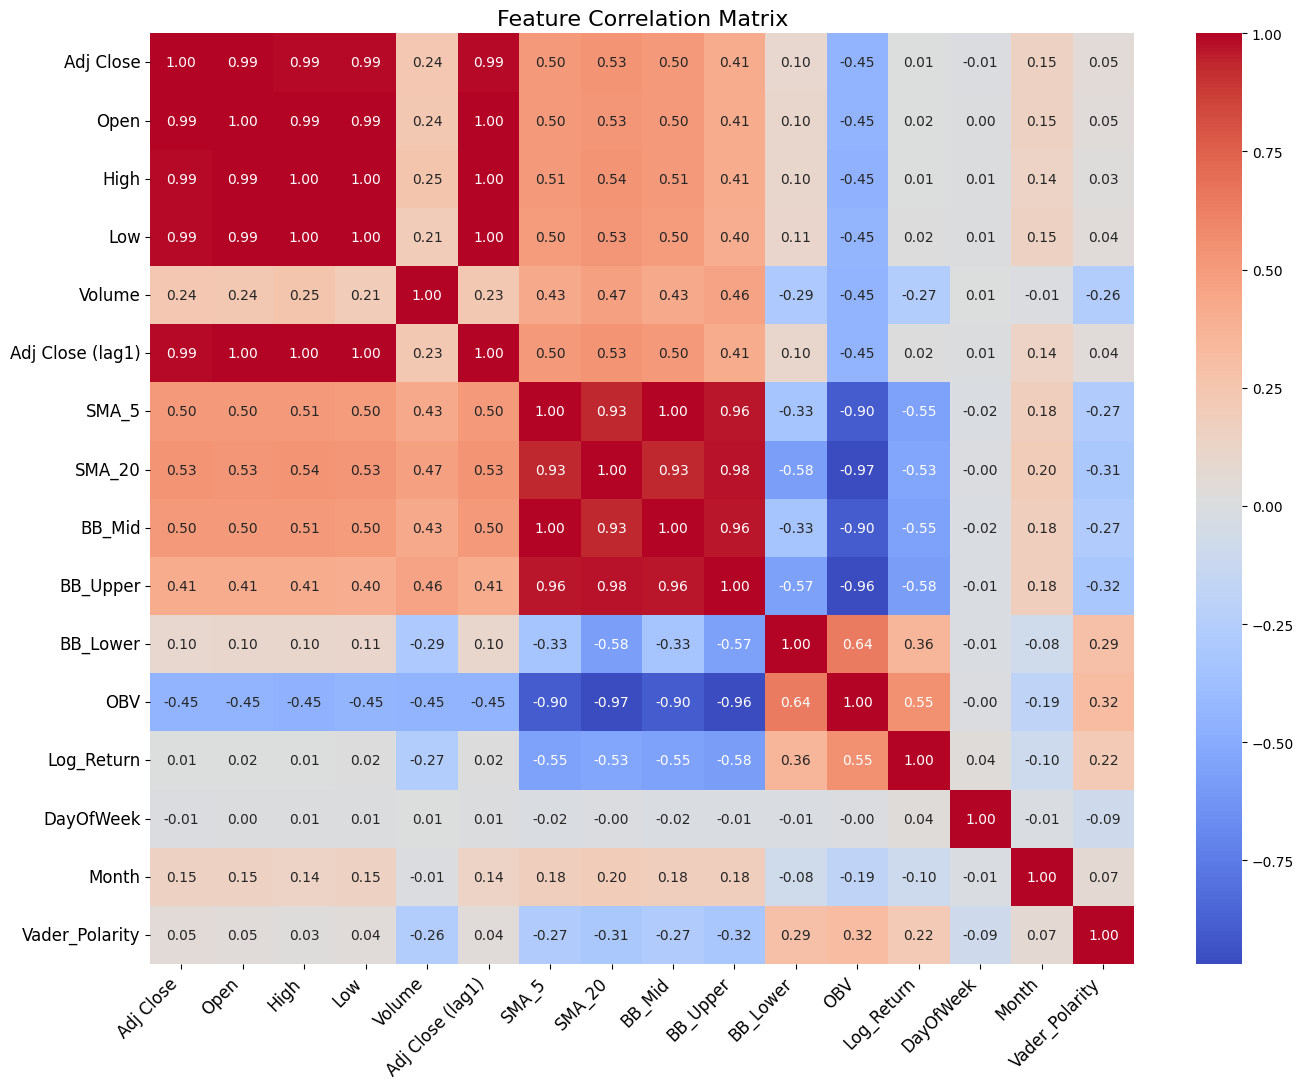

In [64]:
# --- 用于分析的 X_corr，包含目标变量 Adj Close（非shift） ---
X_corr = df[feature_cols].copy()
X_corr = X_corr.iloc[:-1, :]  # 对齐 label（因为 y = shift(-1)）

# --- 2. Correlation Heatmap ---
plt.figure(figsize=(14, 11))
corr_matrix = X_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            annot_kws={"size": 10})  # 更改热力图上的数字字体大小

plt.title("Feature Correlation Matrix", fontsize=16)  # 标题字体大小
plt.xticks(rotation=45, ha='right', fontsize=12)       # x轴字体大小
plt.yticks(rotation=0, fontsize=12)                    # y轴字体大小

plt.tight_layout()
plt.show()

In [65]:
# ✅ 1. 准备 X（剔除当前天 Adj Close）和 y（今天的真实值）
X = df[feature_cols].copy()
X = X.drop(columns=['Adj Close'])  # ❗必须删掉当前天 Adj Close
y = df['Adj Close']                # ✅ y 是今天的实际收盘价

# ✅ 2. 对齐（防止因为 lag、SMA 等造成的缺失）
X = X.iloc[1:, :]   # ❗去掉第一天（因为 lag1 没有值）
y = y.iloc[1:]      # 同步对齐

# ✅ 3. 标准化
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# ✅ 4. 时间序列划分
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, shuffle=False
)

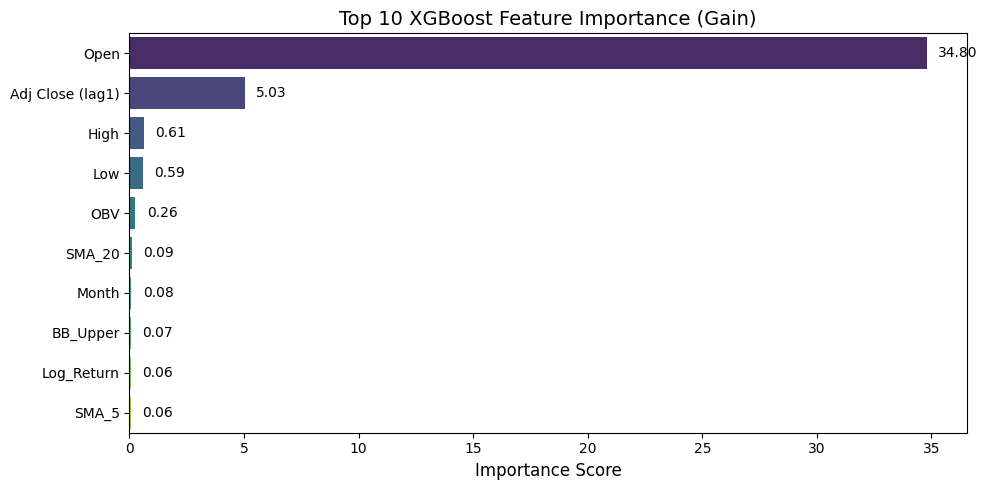

In [66]:
# --- 3. XGBoost Feature Importance ---
xgb_model = xgb.XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train)

importances = xgb_model.get_booster().get_score(importance_type='gain')
importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

imp_df = pd.DataFrame(importances, columns=['Feature', 'Importance']).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=imp_df,
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='viridis',
    dodge=False,
    legend=False
)

# 格式化 x 轴小数位
for i, v in enumerate(imp_df['Importance']):
    plt.text(v + 0.5, i, f'{v:.2f}', va='center', fontsize=10)

plt.title("Top 10 XGBoost Feature Importance (Gain)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

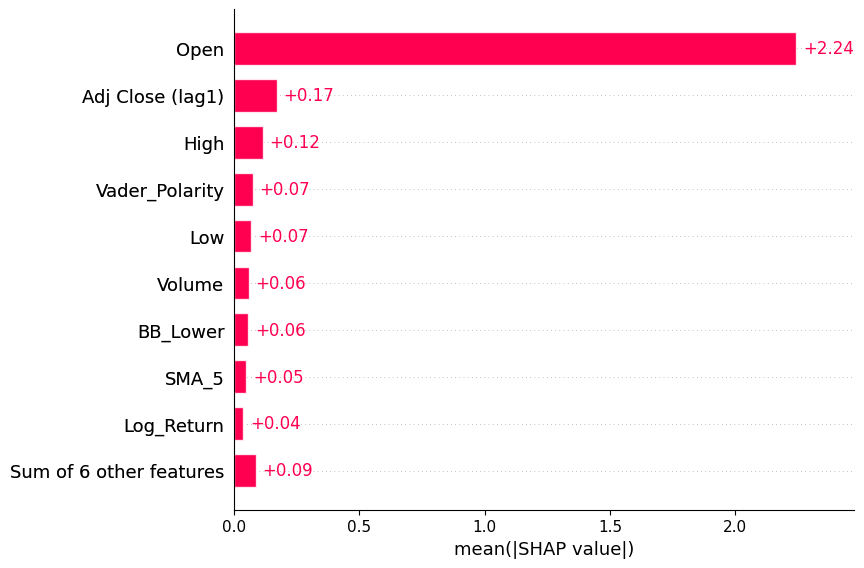

<Figure size 640x480 with 0 Axes>

In [67]:
# --- 4. SHAP with PermutationExplainer (CPU-friendly) ---
explainer = shap.Explainer(xgb_model.predict, X_val, algorithm="permutation")
shap_values = explainer(X_val)

# 设置图像大小 + 显示前10个特征
plt.gcf().set_size_inches(10, 5)
shap.plots.bar(shap_values, max_display=10)
plt.tight_layout()
plt.show()

In [68]:
# ========== 1. 检查并删除高度相关的特征 ==========
X_corr_check = df[feature_cols].copy().iloc[:-1]  # 不影响后续流程
corr_matrix = X_corr_check.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.90)]

print("📉 Dropped (correlated > 0.90):")
for col in to_drop_corr:
    print(f"  · {col}")

# ========== 2. 输出 XGBoost Top 10 特征 ==========
# 假设此处已有 xgb_model 训练完成
importances_dict = xgb_model.get_booster().get_score(importance_type='gain')
top10_sorted = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("\n🌟 Top 10 XGBoost Features (by Gain):")
for i, (feat, score) in enumerate(top10_sorted, 1):
    print(f"  {i:>2d}. {feat:<20} → {score:.2f}")

📉 Dropped (correlated > 0.90):
  · Open
  · High
  · Low
  · Adj Close (lag1)
  · SMA_20
  · BB_Mid
  · BB_Upper
  · OBV

🌟 Top 10 XGBoost Features (by Gain):
   1. Open                 → 34.80
   2. Adj Close (lag1)     → 5.03
   3. High                 → 0.61
   4. Low                  → 0.59
   5. OBV                  → 0.26
   6. SMA_20               → 0.09
   7. Month                → 0.08
   8. BB_Upper             → 0.07
   9. Log_Return           → 0.06
  10. SMA_5                → 0.06


## Time Series Train-Test Split

### 1. Loading Pre-processed Data

In [2]:
company_list = ['TSLA', 'AAPL', 'AMZN', 'GOOGL', 'MSFT']
stock_data_dict = {}

for symbol in company_list:
    path = f"./data/filtered/{symbol}_filtered.csv"
    stock_data_dict[symbol] = pd.read_csv(path)

In [3]:
TSLA = stock_data_dict['TSLA']
AAPL = stock_data_dict['AAPL']
AMZN = stock_data_dict['AMZN']
GOOGL = stock_data_dict['GOOGL']
MSFT = stock_data_dict['MSFT']

In [154]:
df = MSFT.copy()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,SMA_5,SMA_20,...,BB_Upper,BB_Lower,RSI_14,Log_Return,OBV,Prev_Close,Prev_Volume,DayOfWeek,Month,Vader_Polarity
0,2015-01-02,46.660000,47.419998,46.540001,46.759998,40.072136,27913900,MSFT,26.123333,25.620192,...,49.228223,1.735509,46.167054,0.568733,-17072100.0,26.477501,26480000.0,4,1,0.260802
1,2015-01-05,46.369999,46.730000,46.250000,46.330002,39.703636,39673900,MSFT,25.596200,25.620192,...,49.228223,1.735509,46.167054,0.556289,129250300.0,26.562500,257142000.0,0,1,0.244632
2,2015-01-06,46.380001,46.750000,45.540001,45.650002,39.120899,36447900,MSFT,29.531601,25.620192,...,49.228223,1.735509,46.167054,-0.014786,92802400.0,46.330002,39673900.0,1,1,0.211529
3,2015-01-07,45.980000,46.459999,45.490002,46.230000,39.617935,29114100,MSFT,25.133867,25.620192,...,49.228223,1.735509,55.775826,0.604506,-157282400.0,25.257500,46918000.0,2,1,0.256537
4,2015-01-08,46.750000,47.750000,46.720001,47.590000,40.783424,29645200,MSFT,26.170400,25.657208,...,50.044991,2.295809,50.394938,0.630021,161626400.0,25.345501,73054000.0,3,1,0.344753


### 2. Avoid Data Leakage

In [155]:
# Lag technical indicators to avoid leakage
lag_cols = [
    'Adj Close', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_20',
    'BB_Mid', 'BB_Std', 'BB_Upper', 'BB_Lower',
    'RSI_14', 'Log_Return', 'OBV', 'Vader_Polarity'
]

for col in lag_cols:
    if col == "Adj Close":
        df[f"{col} (lag1)"] = df[col].shift(1)
    else:
        df[col] = df[col].shift(1)

feature_cols = [
    'Adj Close',
    'Open', 'High', 'Low', 'Volume', 'Adj Close (lag1)',
    'SMA_5', 'SMA_20', 'BB_Mid', 'BB_Upper', 'BB_Lower',
    'OBV', 'Log_Return', 'DayOfWeek', 'Month',
    'Vader_Polarity'
]

df = df[feature_cols]

In [156]:
df.head()

,Adj Close,Open,High,Low,Volume,Adj Close (lag1),SMA_5,SMA_20,BB_Mid,BB_Upper,BB_Lower,OBV,Log_Return,DayOfWeek,Month,Vader_Polarity
0,40.072136,46.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,NaN
1,39.703636,46.369999,47.419998,46.540001,27913900.0,40.072136,26.123333,25.620192,26.123333,49.228223,1.735509,-17072100.0,0.568733,0,1,0.260802
2,39.120899,46.380001,46.730000,46.250000,39673900.0,39.703636,25.596200,25.620192,25.596200,49.228223,1.735509,129250300.0,0.556289,1,1,0.244632
3,39.617935,45.980000,46.750000,45.540001,36447900.0,39.120899,29.531601,25.620192,29.531601,49.228223,1.735509,92802400.0,-0.014786,2,1,0.211529
4,40.783424,46.750000,46.459999,45.490002,29114100.0,39.617935,25.133867,25.620192,25.133867,49.228223,1.735509,-157282400.0,0.604506,3,1,0.256537


In [157]:
# feature_cols = [
#     'Adj Close',  # should be the first one for Y
#     'Adj Close (lag1)',
#     'SMA_5',              # short-term trend
#     'Volume',
#     'BB_Mid',           # risk signal
#     'Log_Return',
#     'DayOfWeek', 
#     'Month',
#     'Vader_Polarity'  # should be the last one for SENTIMENT
# ]

In [158]:
feature_cols = [
    'Adj Close',
    'Open', 'High', 'Low', 'Volume', 'Adj Close (lag1)',
    'SMA_5', 'SMA_20', 'BB_Mid', 'BB_Upper', 'BB_Lower',
    'OBV', 'Log_Return', 'DayOfWeek', 'Month',
    'Vader_Polarity'
]

### Define Rolling Window & Prediction Day

In [159]:
# Step 0: Define sliding window parameters
n_past = 5     # Use past 5 days
n_future = 1   # Predict next 1 day

### Train-Test Split

In [160]:
train_size = 0.7
train_split_idx = int(train_size * len(df))

In [161]:
df_filtered = df[feature_cols]
df_filtered = df_filtered.iloc[1:] # delete nan ❗去掉第一天（因为 lag1 没有值）

# Step 0: Define split boundaries BEFORE scaling
train_df = df_filtered.iloc[:train_split_idx]
test_df  = df_filtered.iloc[train_split_idx:]

# Step 1: Fit scaler only on training data (Avoid Data Leakage)
scaler = MinMaxScaler()
scaler.fit(train_df)

scaler_target = MinMaxScaler()
scaler_target.fit(train_df[['Adj Close']])

# Step 2: Scale training and test data separately
train_scaled = scaler.transform(train_df)
test_scaled  = scaler.transform(test_df)

# # Step 3: For inference later, only scale ['Adj Close']
# scaler_for_inference = MinMaxScaler()
# scaler_for_inference.fit(train_df[['Adj Close']])
# # Now you can transform when needed during inference
# train_actual_scaled_close = scaler_for_inference.transform(train_df[['Adj Close']])
# test_actual_scaled_close = scaler_for_inference.transform(test_df[['Adj Close']])

# Step 3: Reconstruct sliding windows for train and test
def create_sequences(data, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, 1:])
        y.append(data[i + n_future - 1:i + n_future, [0]])  # Predict Adj Close
    return np.array(X), np.array(y)

trainX, trainY = create_sequences(train_scaled, n_past, n_future)
testX, testY   = create_sequences(test_scaled, n_past, n_future)

# trainY = trainY.reshape(-1, 1)
# testY = testY.reshape(-1, 1)

print('TrainX shape = {}'.format(trainX.shape))
print('TrainY shape = {}'.format(trainY.shape))
print('TestX shape = {}'.format(testX.shape))
print('TestY shape = {}'.format(testY.shape))

TrainX shape = (875, 5, 15)
TrainY shape = (875, 1, 1)
TestX shape = (372, 5, 15)
TestY shape = (372, 1, 1)


### (Un)Sentiment Split

In [162]:
# Without Sentiment (Baseline Model)
trainX_wo_tweet = trainX[:, :, :-1]  # Exclude last feature
testX_wo_tweet  = testX[:, :, :-1]
trainY_wo_tweet = trainY
testY_wo_tweet  = testY

# With Sentiment (Tweet-based Model)
trainX_with_tweet = trainX
testX_with_tweet  = testX
trainY_with_tweet = trainY
testY_with_tweet  = testY

In [163]:
print(trainX_with_tweet.shape, trainY_with_tweet.shape)

(875, 5, 15) (875, 1, 1)


### Random Seed

In [164]:
def set_all_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()  # TensorFlow 2.12+

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_all_seeds(seed=42)